<a href="https://colab.research.google.com/github/samirp92/Final-Year-Project-Time-Series-Forecasting-/blob/main/LSTM_Electric_Power_Consumption_Forecasting_Student_ID_21072112.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the required libraries

In [ ]:
# Disable warnings in the notebook for maintaining clean output
import warnings
warnings.filterwarnings('ignore')

# Import the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [ ]:
# Mount the google drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

# Set the root path directory
root_path = "/content/drive/MyDrive/Final Year Project"

Mounted at /content/drive


# Data Loading

In [ ]:
# Load the data from google drive
df = pd.read_csv("/content/drive/MyDrive/Final Year Project/household_power_consumption.txt", sep=';')
df

Date      Time Global_active_power Global_reactive_power  \
0        16/12/2006  17:24:00               4.216                 0.418   
1        16/12/2006  17:25:00               5.360                 0.436   
2        16/12/2006  17:26:00               5.374                 0.498   
3        16/12/2006  17:27:00               5.388                 0.502   
4        16/12/2006  17:28:00               3.666                 0.528   
...             ...       ...                 ...                   ...   
2075254  26/11/2010  20:58:00               0.946                   0.0   
2075255  26/11/2010  20:59:00               0.944                   0.0   
2075256  26/11/2010  21:00:00               0.938                   0.0   
2075257  26/11/2010  21:01:00               0.934                   0.0   
2075258  26/11/2010  21:02:00               0.932                   0.0   

         Voltage Global_intensity Sub_metering_1 Sub_metering_2  \
0        234.840           18.400          0.000          1.000   
1        233.630           23.000          0.000          1.000   
2        233.290           23.000          0.000          2.000   
3        233.740           23.000          0.000          1.000   
4        235.680           15.800          0.000          1.000   
...          ...              ...            ...            ...   
2075254   240.43              4.0            0.0            0.0   
2075255    240.0              4.0            0.0            0.0   
2075256   239.82              3.8            0.0            0.0   
2075257    239.7              3.8            0.0            0.0   
2075258   239.55              3.8            0.0            0.0   

         Sub_metering_3  
0                  17.0  
1                  16.0  
2                  17.0  
3                  17.0  
4                  17.0  
...                 ...  
2075254             0.0  
2075255             0.0  
2075256             0.0  
2075257             0.0  
2075258             0.0  

[2075259 rows x 9 columns]

In [ ]:
# Display DataFrame information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


# Data Preprocessing

In [ ]:
# Replace '?' with NaN values
df.replace('?', np.nan, inplace=True)

In [ ]:
# Convert numeric columns to appropriate data types
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
df['Global_reactive_power'] = pd.to_numeric(df['Global_reactive_power'], errors='coerce')
df['Voltage'] = pd.to_numeric(df['Voltage'], errors='coerce')
df['Global_intensity'] = pd.to_numeric(df['Global_intensity'], errors='coerce')
df['Sub_metering_1'] = pd.to_numeric(df['Sub_metering_1'], errors='coerce')
df['Sub_metering_2'] = pd.to_numeric(df['Sub_metering_2'], errors='coerce')

# Confirm the updated data types
print(df.dtypes)

Date                      object
Time                      object
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object


In [ ]:
# Convert the 'Date' and 'Time' columns to a single 'date_time' column
df['date_time'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

# Convert the 'date_time' column to datetime format
df['date_time'] = pd.to_datetime(df['date_time'])

# Set the 'date_time' column as the index
df.set_index('date_time', inplace=True)

# Drop the original 'Date' and 'Time' columns
df.drop(columns=['Date', 'Time'], inplace=True)

# Copy the original DataFrame into a new DataFrame
df_copy = df.copy()
df_copy

Global_active_power  Global_reactive_power  Voltage  \
date_time                                                                  
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   
...                                  ...                    ...      ...   
2010-11-26 20:58:00                0.946                  0.000   240.43   
2010-11-26 20:59:00                0.944                  0.000   240.00   
2010-11-26 21:00:00                0.938                  0.000   239.82   
2010-11-26 21:01:00                0.934                  0.000   239.70   
2010-11-26 21:02:00                0.932                  0.000   239.55   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
date_time                                                               
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00              15.8             0.0             1.0   
...                               ...             ...             ...   
2010-11-26 20:58:00               4.0             0.0             0.0   
2010-11-26 20:59:00               4.0             0.0             0.0   
2010-11-26 21:00:00               3.8             0.0             0.0   
2010-11-26 21:01:00               3.8             0.0             0.0   
2010-11-26 21:02:00               3.8             0.0             0.0   

                     Sub_metering_3  
date_time                            
2006-12-16 17:24:00            17.0  
2006-12-16 17:25:00            16.0  
2006-12-16 17:26:00            17.0  
2006-12-16 17:27:00            17.0  
2006-12-16 17:28:00            17.0  
...                             ...  
2010-11-26 20:58:00             0.0  
2010-11-26 20:59:00             0.0  
2010-11-26 21:00:00             0.0  
2010-11-26 21:01:00             0.0  
2010-11-26 21:02:00             0.0  

[2075259 rows x 7 columns]

# Data Imputation

In [ ]:
# Check Missing Values
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [ ]:
# Apply MICE imputer
imputer = IterativeImputer(random_state=0)
df_imputed = imputer.fit_transform(df)

# Convert back to DataFrame
df_imputed = pd.DataFrame(df_imputed, index=df.index, columns=df.columns)

# Fill NaN values using the mean for each column
#df_imputed = df.copy()
#df_imputed.fillna(df.mean(), inplace=True)

# Save the DataFrame to an Excel file
df_imputed.to_csv('df_imputed.csv')

In [ ]:
# Check Missing Values after imputation
df_imputed.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

Note:-

(Global_active_power*1000/60 - Sub_metering_1 - Sub_metering_2 - Sub_metering_3) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3

In [ ]:
# Creating new variable for remaining power consumption in watt hour
equation1 = (df_imputed['Global_active_power']*1000/60)
equation2 = df_imputed['Sub_metering_1'] + df_imputed['Sub_metering_2'] + df_imputed['Sub_metering_3']
df_imputed['Sub_metering_4'] = equation1 - equation2
df_imputed

Global_active_power  Global_reactive_power  Voltage  \
date_time                                                                  
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   
...                                  ...                    ...      ...   
2010-11-26 20:58:00                0.946                  0.000   240.43   
2010-11-26 20:59:00                0.944                  0.000   240.00   
2010-11-26 21:00:00                0.938                  0.000   239.82   
2010-11-26 21:01:00                0.934                  0.000   239.70   
2010-11-26 21:02:00                0.932                  0.000   239.55   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
date_time                                                               
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00              15.8             0.0             1.0   
...                               ...             ...             ...   
2010-11-26 20:58:00               4.0             0.0             0.0   
2010-11-26 20:59:00               4.0             0.0             0.0   
2010-11-26 21:00:00               3.8             0.0             0.0   
2010-11-26 21:01:00               3.8             0.0             0.0   
2010-11-26 21:02:00               3.8             0.0             0.0   

                     Sub_metering_3  Sub_metering_4  
date_time                                            
2006-12-16 17:24:00            17.0       52.266667  
2006-12-16 17:25:00            16.0       72.333333  
2006-12-16 17:26:00            17.0       70.566667  
2006-12-16 17:27:00            17.0       71.800000  
2006-12-16 17:28:00            17.0       43.100000  
...                             ...             ...  
2010-11-26 20:58:00             0.0       15.766667  
2010-11-26 20:59:00             0.0       15.733333  
2010-11-26 21:00:00             0.0       15.633333  
2010-11-26 21:01:00             0.0       15.566667  
2010-11-26 21:02:00             0.0       15.533333  

[2075259 rows x 8 columns]

# Hourly resampled data

In [ ]:
# Resampled the data
hourly_resampled = df_imputed.resample('H').mean()

# Save the data
hourly_resampled.to_csv('hourly_resampled.csv')

## EDA

In [ ]:
# Define a function to plot the visualization, distribution and correlation of resampled data
def df_visu_dist_corr(df, resample_type, title):

  # Resample the data
  df_resampled = df.resample(resample_type).mean()

  print('Shape after %s resampling of data : %s ' %(title, df_resampled.shape))
  print('\n')

  # Plot Resampled Data set
  df_resampled.plot(subplots=True, figsize=(25,20))
  plt.suptitle("Visualization of %s Resampled Data" %title, fontsize=30, color='blue')
  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.show()

  # Plot distribution
  print(' \n\n************************************************ Distribution Plot for %s Resampled Data **************************************************' %title, end="\n\n")
  df_resampled.hist(figsize=(15, 10), bins=50)
  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.gcf().set_dpi(300)
  plt.show()

  # Plot correlation plot
  print(' \n\n************************************************ Correlation Plot for %s Resampled Data **************************************************' %title, end="\n\n")
  plt.figure(figsize=(10,6))
  sns.heatmap(df_resampled.corr(), annot=True, cmap='coolwarm', fmt='.2f')
  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.gcf().set_dpi(200)
  plt.show()

Shape after Hourly resampling of data : (34589, 8) 




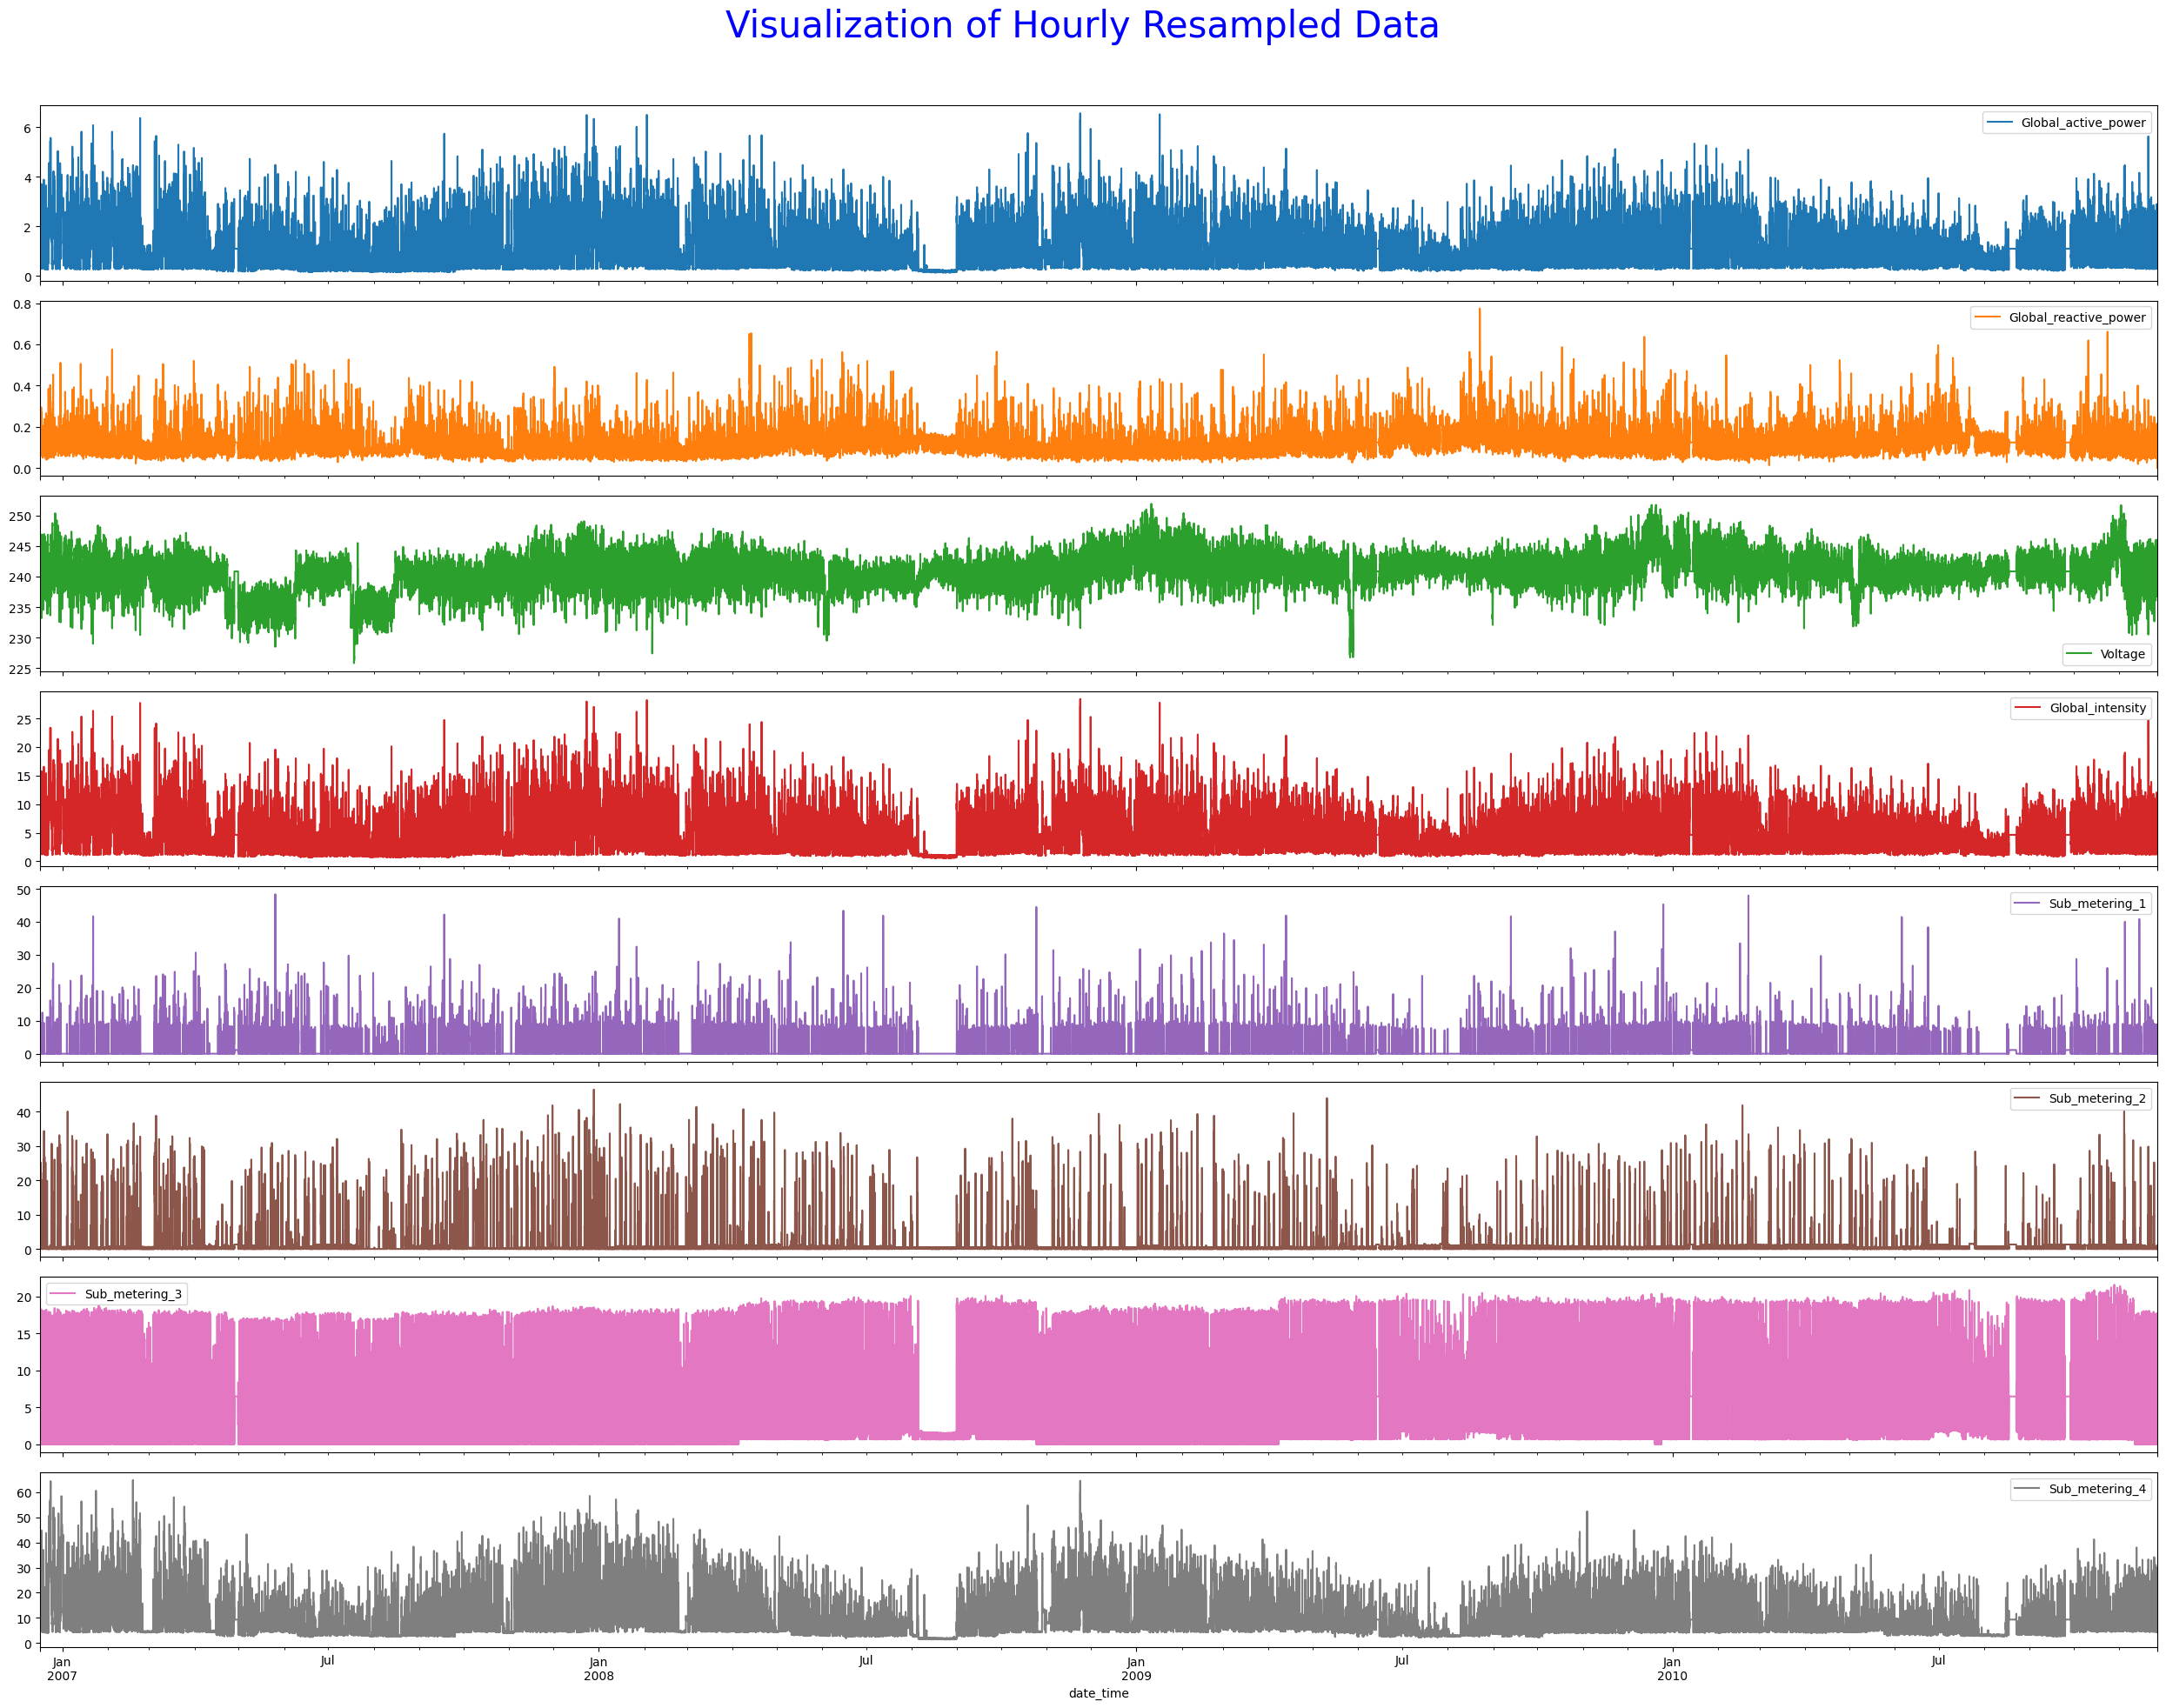

 

************************************************ Distribution Plot for Hourly Resampled Data **************************************************



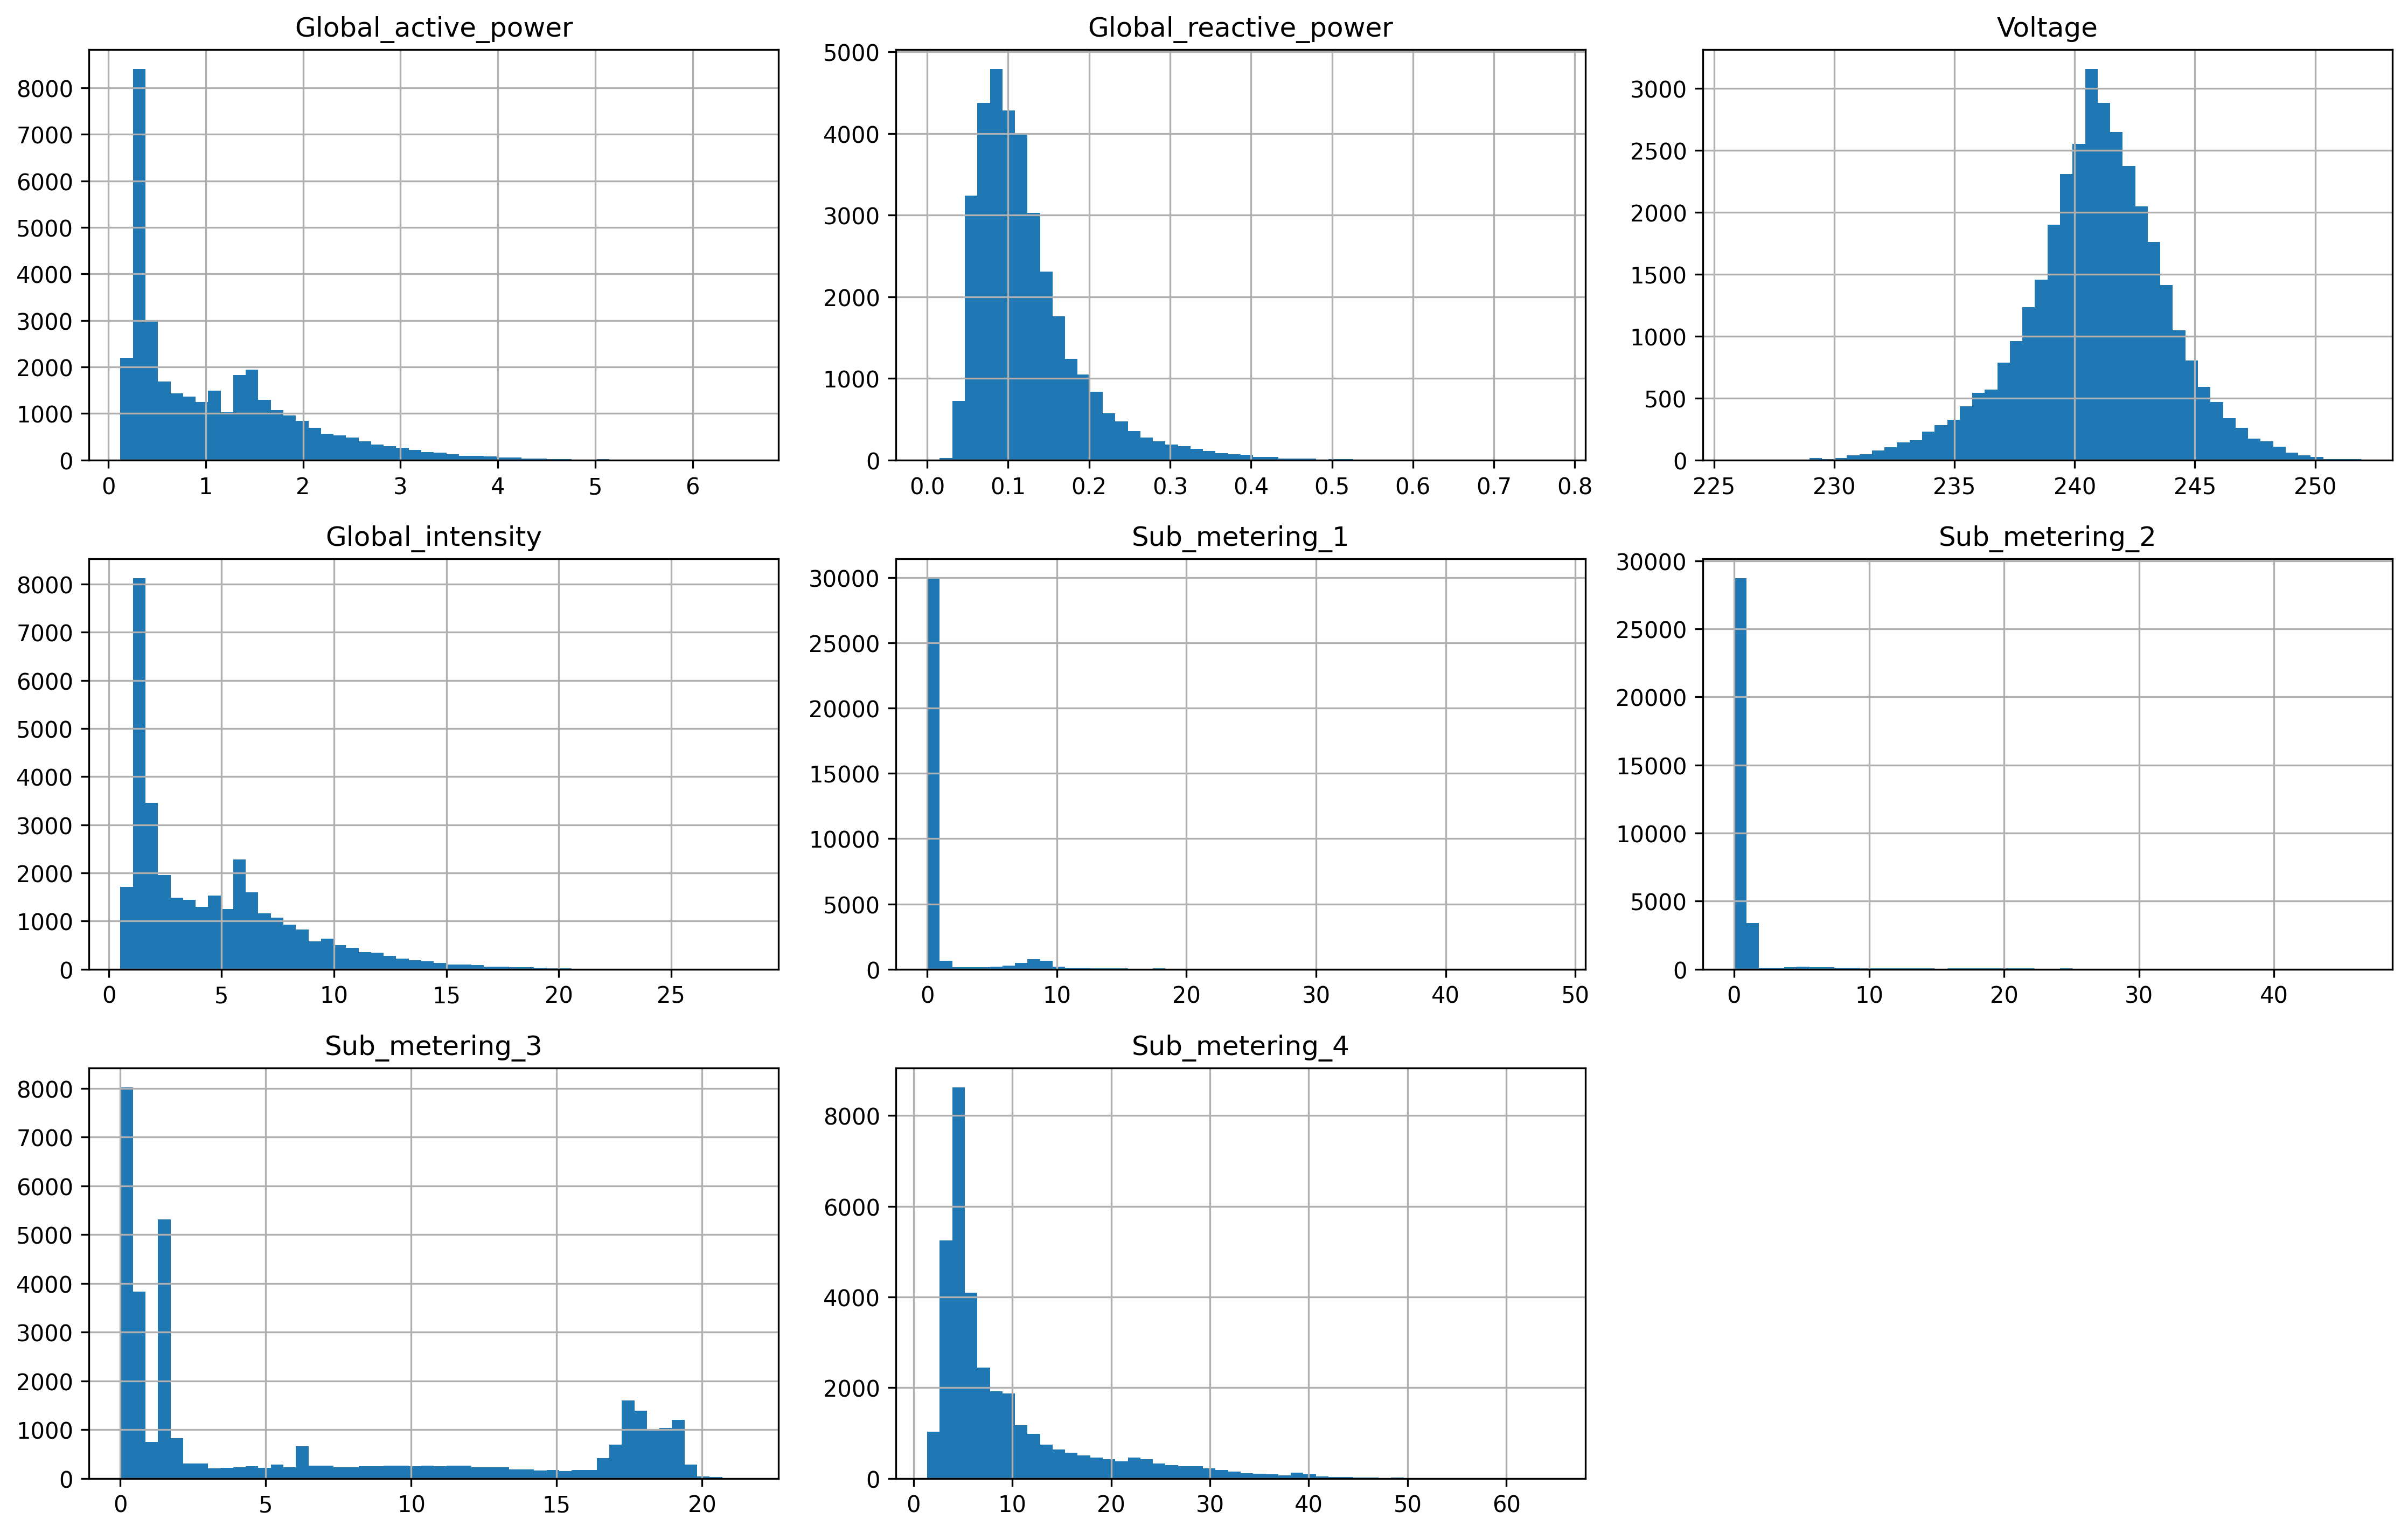

 

************************************************ Correlation Plot for Hourly Resampled Data **************************************************



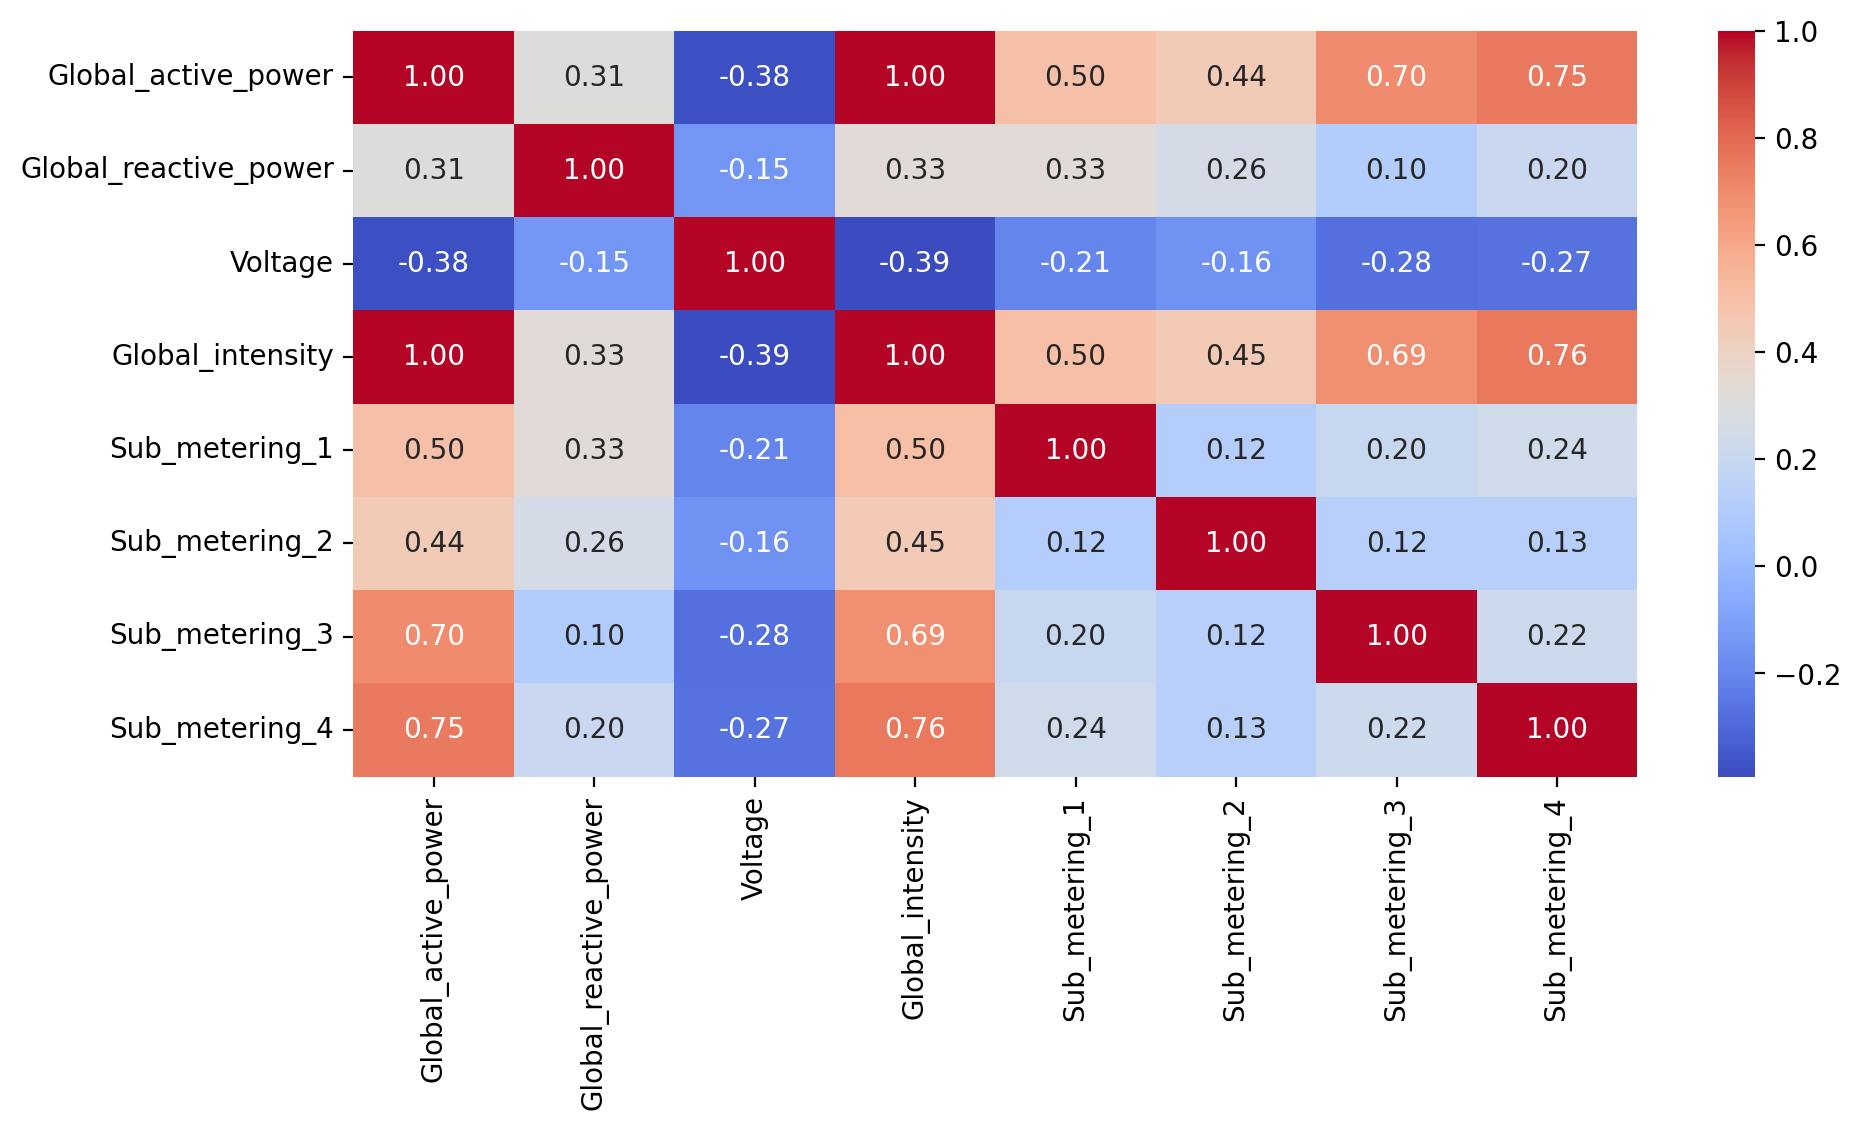

In [ ]:
# Plot the visualization, distribution and correlation of Hourly resampled data
df_visu_dist_corr(df_imputed, "H", "Hourly")

In [ ]:
# Remove higly correlated columns
df1 = hourly_resampled.drop(['Global_intensity','Sub_metering_4'], axis=1)
df1

Global_active_power  Global_reactive_power     Voltage  \
date_time                                                                     
2006-12-16 17:00:00             4.222889               0.229000  234.643889   
2006-12-16 18:00:00             3.632200               0.080033  234.580167   
2006-12-16 19:00:00             3.400233               0.085233  233.232500   
2006-12-16 20:00:00             3.268567               0.075100  234.071500   
2006-12-16 21:00:00             3.056467               0.076667  237.158667   
...                                  ...                    ...         ...   
2010-11-26 17:00:00             1.725900               0.061400  237.069667   
2010-11-26 18:00:00             1.573467               0.053700  237.531833   
2010-11-26 19:00:00             1.659333               0.060033  236.741000   
2010-11-26 20:00:00             1.163700               0.061167  239.396000   
2010-11-26 21:00:00             0.934667               0.000000  239.690000   

                     Sub_metering_1  Sub_metering_2  Sub_metering_3  
date_time                                                            
2006-12-16 17:00:00             0.0        0.527778       16.861111  
2006-12-16 18:00:00             0.0        6.716667       16.866667  
2006-12-16 19:00:00             0.0        1.433333       16.683333  
2006-12-16 20:00:00             0.0        0.000000       16.783333  
2006-12-16 21:00:00             0.0        0.416667       17.216667  
...                             ...             ...             ...  
2010-11-26 17:00:00             0.0        0.000000       12.866667  
2010-11-26 18:00:00             0.0        0.000000        0.000000  
2010-11-26 19:00:00             0.0        0.066667        0.000000  
2010-11-26 20:00:00             0.0        1.066667        0.000000  
2010-11-26 21:00:00             0.0        0.000000        0.000000  

[34589 rows x 6 columns]

## Data Normalization

In [ ]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df1 = scaler.fit_transform(df1)

# Shape of scaled data
scaled_df1.shape

(34589, 6)

## LSTM model-1 Adam(learning_rate=0.001, epochs=20, batch_size=32)

(27652, 24, 6) (27652,) (6913, 24, 6) (6913,)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 100)                 │          42,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,901 (167.58 KB)

 Trainable params: 42,901 (167.58 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
865/865 - 8s - 9ms/step - loss: 0.0185 - val_loss: 0.0134
Epoch 2/20
865/865 - 8s - 9ms/step - loss: 0.0139 - val_loss: 0.0106
Epoch 3/20
865/865 - 6s - 6ms/step - loss: 0.0121 - val_loss: 0.0095
Epoch 4/20
865/865 - 13s - 15ms/step - loss: 0.0111 - val_loss: 0.0093
Epoch 5/20
865/865 - 5s - 6ms/step - loss: 0.0106 - val_loss: 0.0094
Epoch 6/20
865/865 - 11s - 12ms/step - loss: 0.0102 - val_loss: 0.0089
Epoch 7/20
865/865 - 9s - 11ms/step - loss: 0.0099 - val_loss: 0.0087
Epoch 8/20
865/865 - 8s - 9ms/step - loss: 0.0096 - val_loss: 0.0085
Epoch 9/20
865/865 - 8s - 9ms/step - loss: 0.0095 - val_loss: 0.0084
Epoch 10/20
865/865 - 4s - 5ms/step - loss: 0.0093 - val_loss: 0.0082
Epoch 11/20
865/865 - 4s - 5ms/step - loss: 0.0092 - val_loss: 0.0084
Epoch 12/20
865/865 - 6s - 6ms/step - loss: 0.0090 - val_loss: 0.0081
Epoch 13/20
865/865 - 10s - 12ms/step - loss: 0.0089 - val_loss: 0.0080
Epoch 14/20
865/865 - 8s - 10ms/step - loss: 0.0088 - val_loss: 0.0079
Epoch 15/20
865/865 -

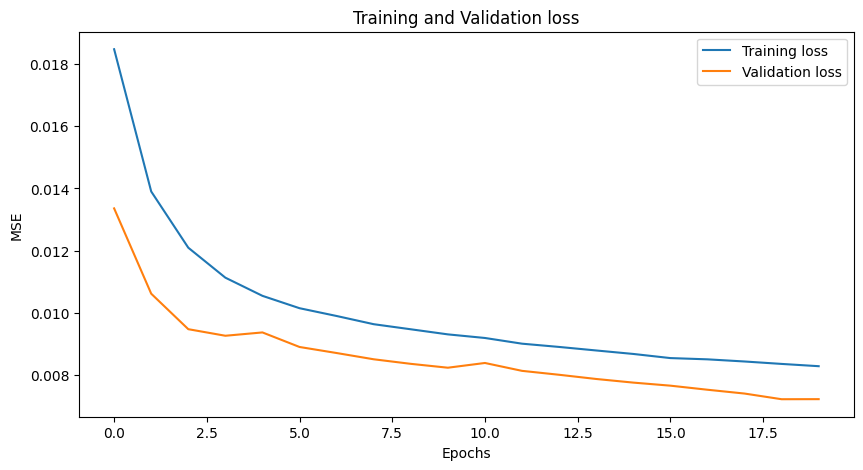

865/865 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Train MAE: 0.480
Train MAPE: 0.853
Train MSE: 0.376
Train RMSE: 0.613

Test MAE: 0.437
Test MAPE: 0.853
Test MSE: 0.300
Test RMSE: 0.547


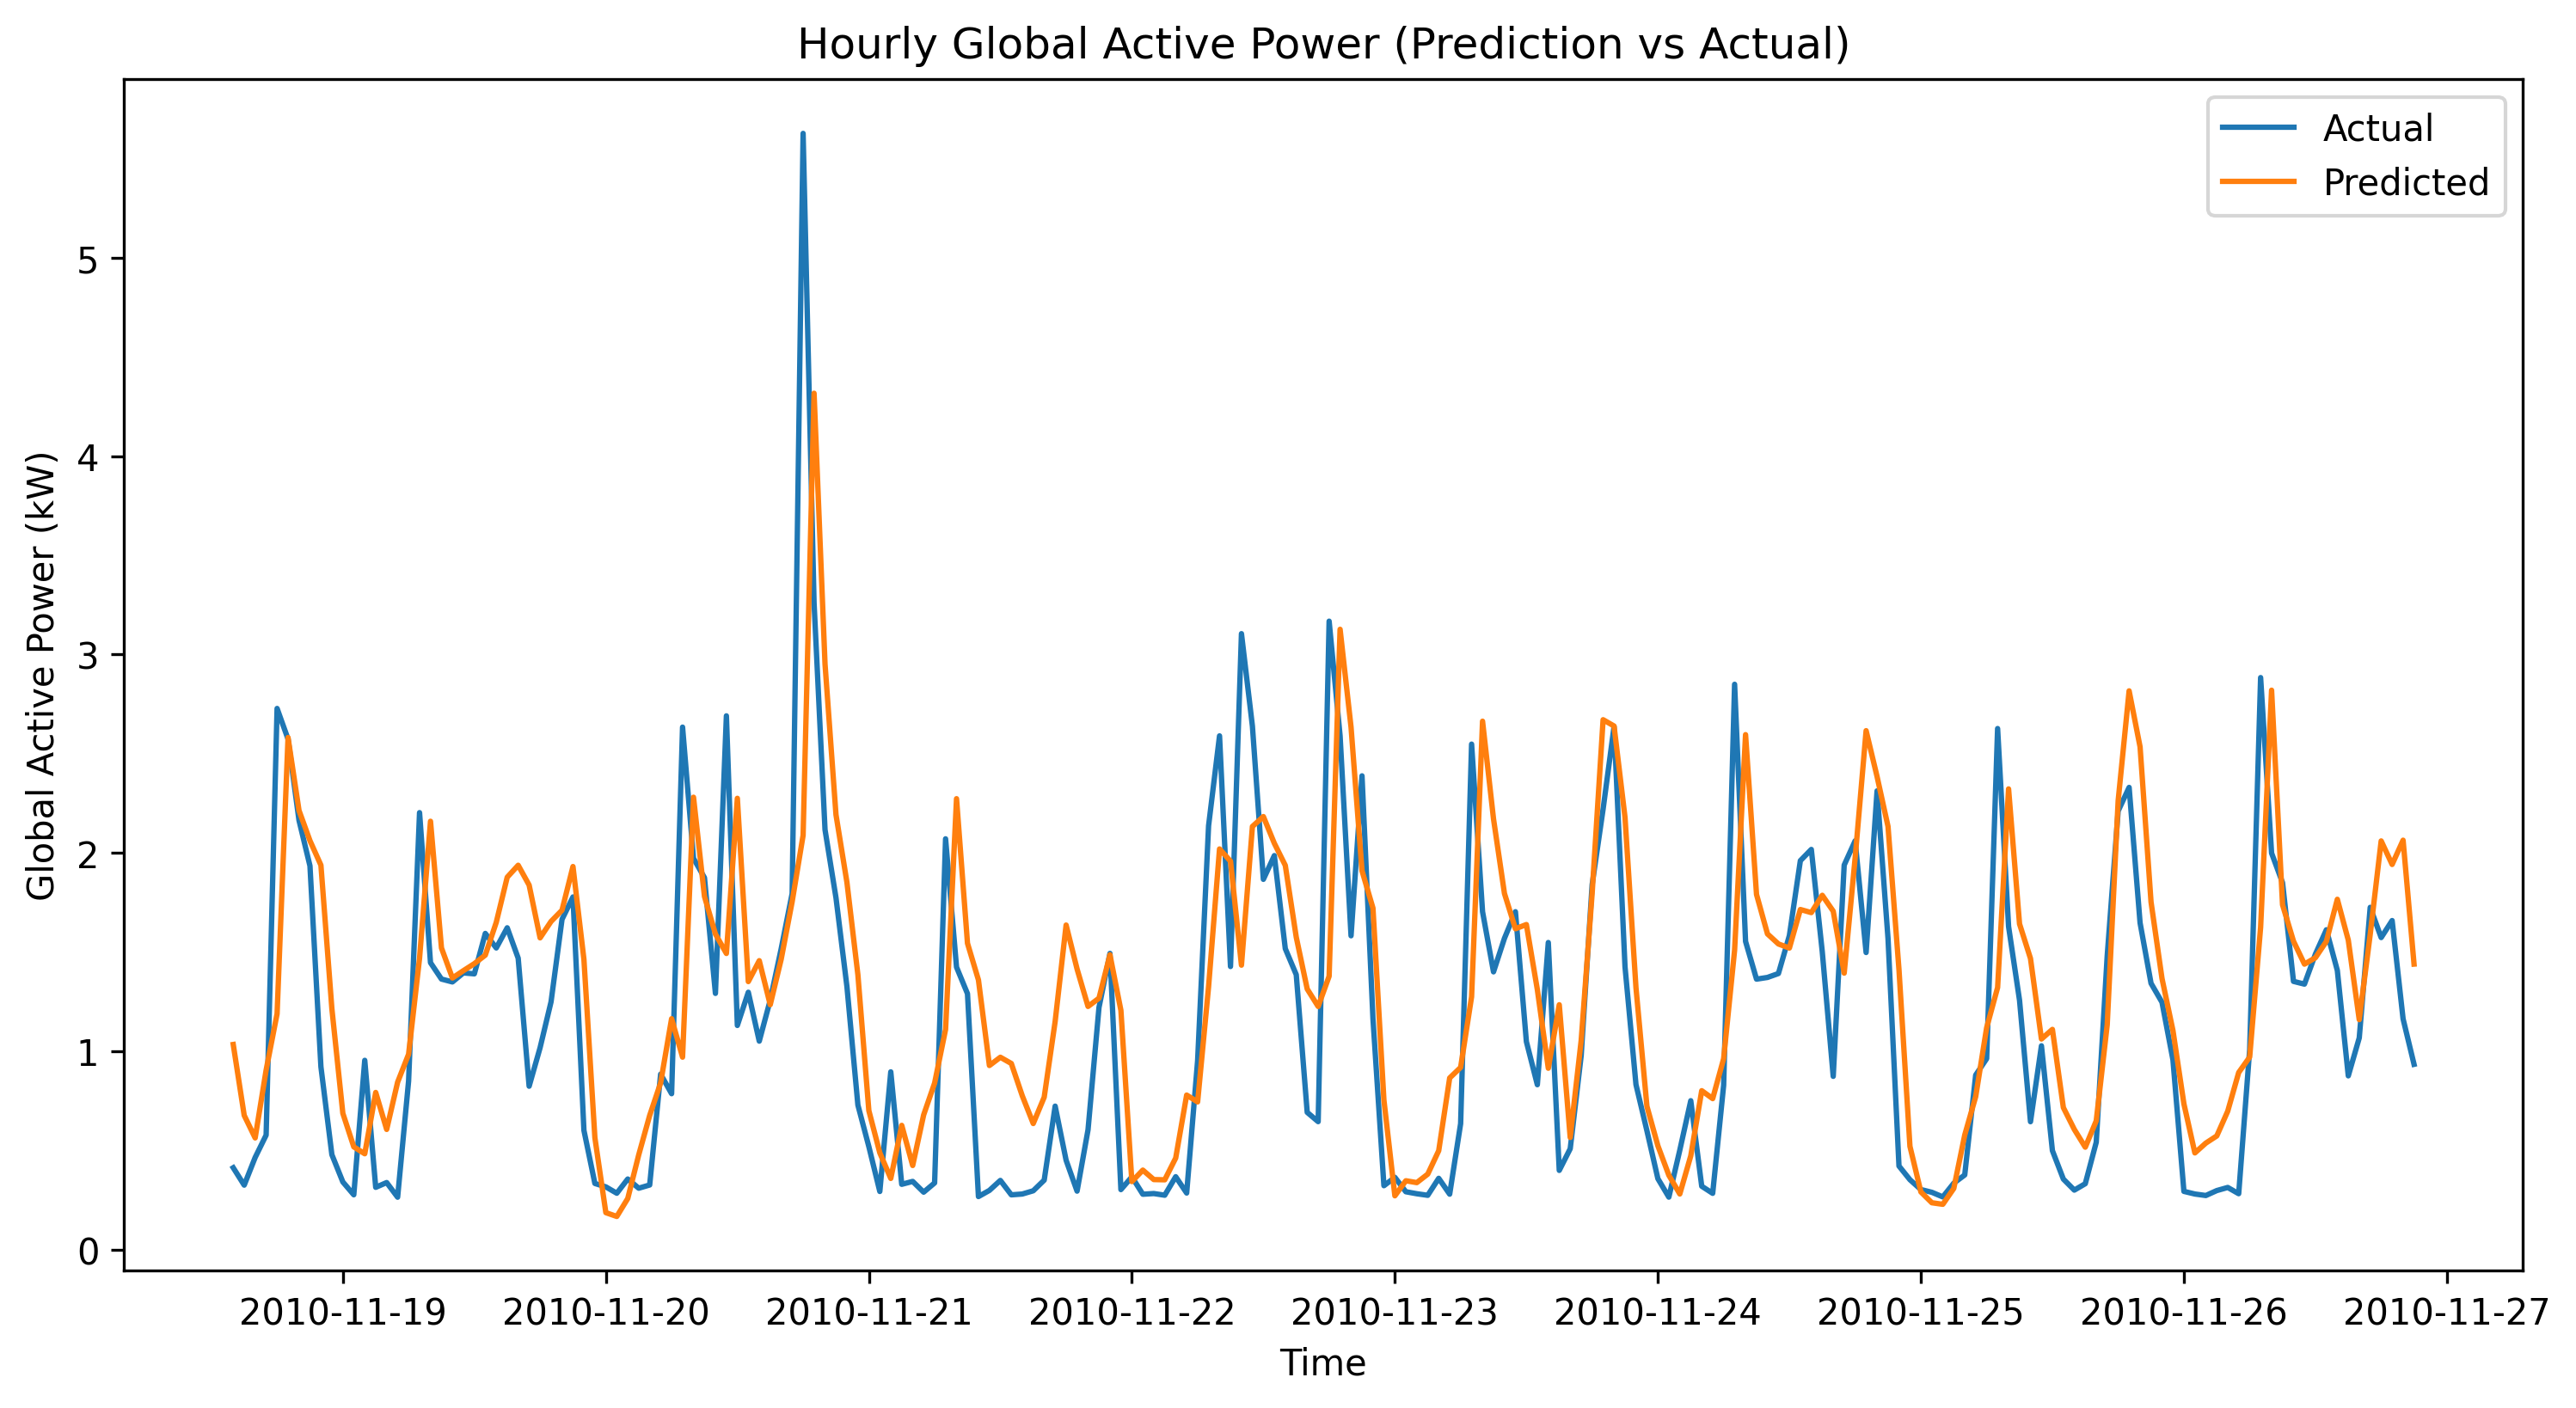

In [ ]:
# Define sequence length and features
sequence_length = 24             # Number of time steps to consider in each sequence
num_features = len(df1.columns)  # Number of features

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_df1) - sequence_length):
    seq = scaled_df1[i:i+sequence_length]
    label = scaled_df1[i+sequence_length][0]  # 'Global_Active_Power' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.80 * len(sequences))
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

# Check the shape of Train & Test Split
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# Create the LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))

# See the summary of model
model.summary()

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

# Fit the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test),
                    verbose=2, shuffle=False)

# Plot the training and validation loss (MSE)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

# Predict train and test data using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
y_train_copies = np.repeat(y_train.reshape(-1, 1), X_train.shape[-1], axis=-1)
true_y_train = scaler.inverse_transform(y_train_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict, df1.shape[1], axis=-1)
pred_y_train = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
y_test_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
true_y_test = scaler.inverse_transform(y_test_copies)[:,0]

# predicted values for test data
test_prediction_copies = np.repeat(test_predict, df1.shape[1], axis=-1)
pred_y_test = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print(f'\nTrain MAE: {mean_absolute_error(true_y_train, pred_y_train):.3f}')
print(f'Train MAPE: {mean_absolute_percentage_error(true_y_train, pred_y_train):.3f}')
print(f'Train MSE: {mean_squared_error(true_y_train, pred_y_train):.3f}')
print(f'Train RMSE: {np.sqrt(mean_squared_error(true_y_train, pred_y_train)):.3f}')

print(f'\nTest MAE: {mean_absolute_error(true_y_test, pred_y_test):.3f}')
print(f'Test MAPE: {mean_absolute_percentage_error(true_y_train, pred_y_train):.3f}')
print(f'Test MSE: {mean_squared_error(true_y_test, pred_y_test):.3f}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(true_y_test, pred_y_test)):.3f}')

# Plotting Hourly Global Active Power (Prediction vs Actual)
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df1.index[-200:], true_y_test[-200:], label='Actual')
plt.plot(df1.index[-200:], pred_y_test[-200:], label='Predicted')
plt.title('Hourly Global Active Power (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

## LSTM model-2 Adam(learning_rate=0.001, epochs=50, batch_size=64)

(27652, 24, 6) (27652,) (6913, 24, 6) (6913,)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                        │ (None, 100)                 │          42,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,901 (167.58 KB)

 Trainable params: 42,901 (167.58 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
433/433 - 3s - 8ms/step - loss: 0.0184 - val_loss: 0.0110
Epoch 2/50
433/433 - 2s - 5ms/step - loss: 0.0149 - val_loss: 0.0100
Epoch 3/50
433/433 - 4s - 8ms/step - loss: 0.0132 - val_loss: 0.0092
Epoch 4/50
433/433 - 6s - 13ms/step - loss: 0.0121 - val_loss: 0.0086
Epoch 5/50
433/433 - 3s - 6ms/step - loss: 0.0115 - val_loss: 0.0084
Epoch 6/50
433/433 - 6s - 13ms/step - loss: 0.0110 - val_loss: 0.0082
Epoch 7/50
433/433 - 6s - 13ms/step - loss: 0.0107 - val_loss: 0.0081
Epoch 8/50
433/433 - 4s - 9ms/step - loss: 0.0104 - val_loss: 0.0078
Epoch 9/50
433/433 - 5s - 12ms/step - loss: 0.0102 - val_loss: 0.0078
Epoch 10/50
433/433 - 4s - 10ms/step - loss: 0.0099 - val_loss: 0.0077
Epoch 11/50
433/433 - 5s - 11ms/step - loss: 0.0098 - val_loss: 0.0076
Epoch 12/50
433/433 - 4s - 9ms/step - loss: 0.0096 - val_loss: 0.0074
Epoch 13/50
433/433 - 4s - 10ms/step - loss: 0.0095 - val_loss: 0.0074
Epoch 14/50
433/433 - 4s - 10ms/step - loss: 0.0094 - val_loss: 0.0073
Epoch 15/50
433/433 -

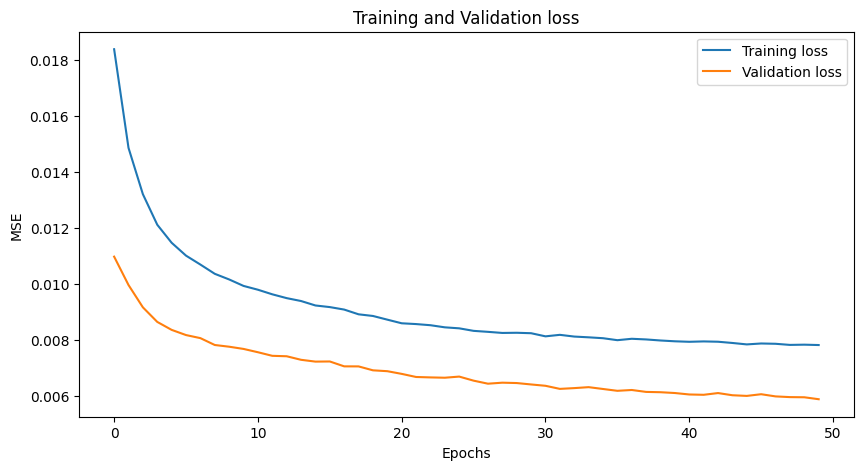

865/865 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Train MAE: 0.414
Train MAPE: 0.637
Train MSE: 0.321
Train RMSE: 0.567

Test MAE: 0.369
Test MAPE: 0.637
Test MSE: 0.244
Test RMSE: 0.494


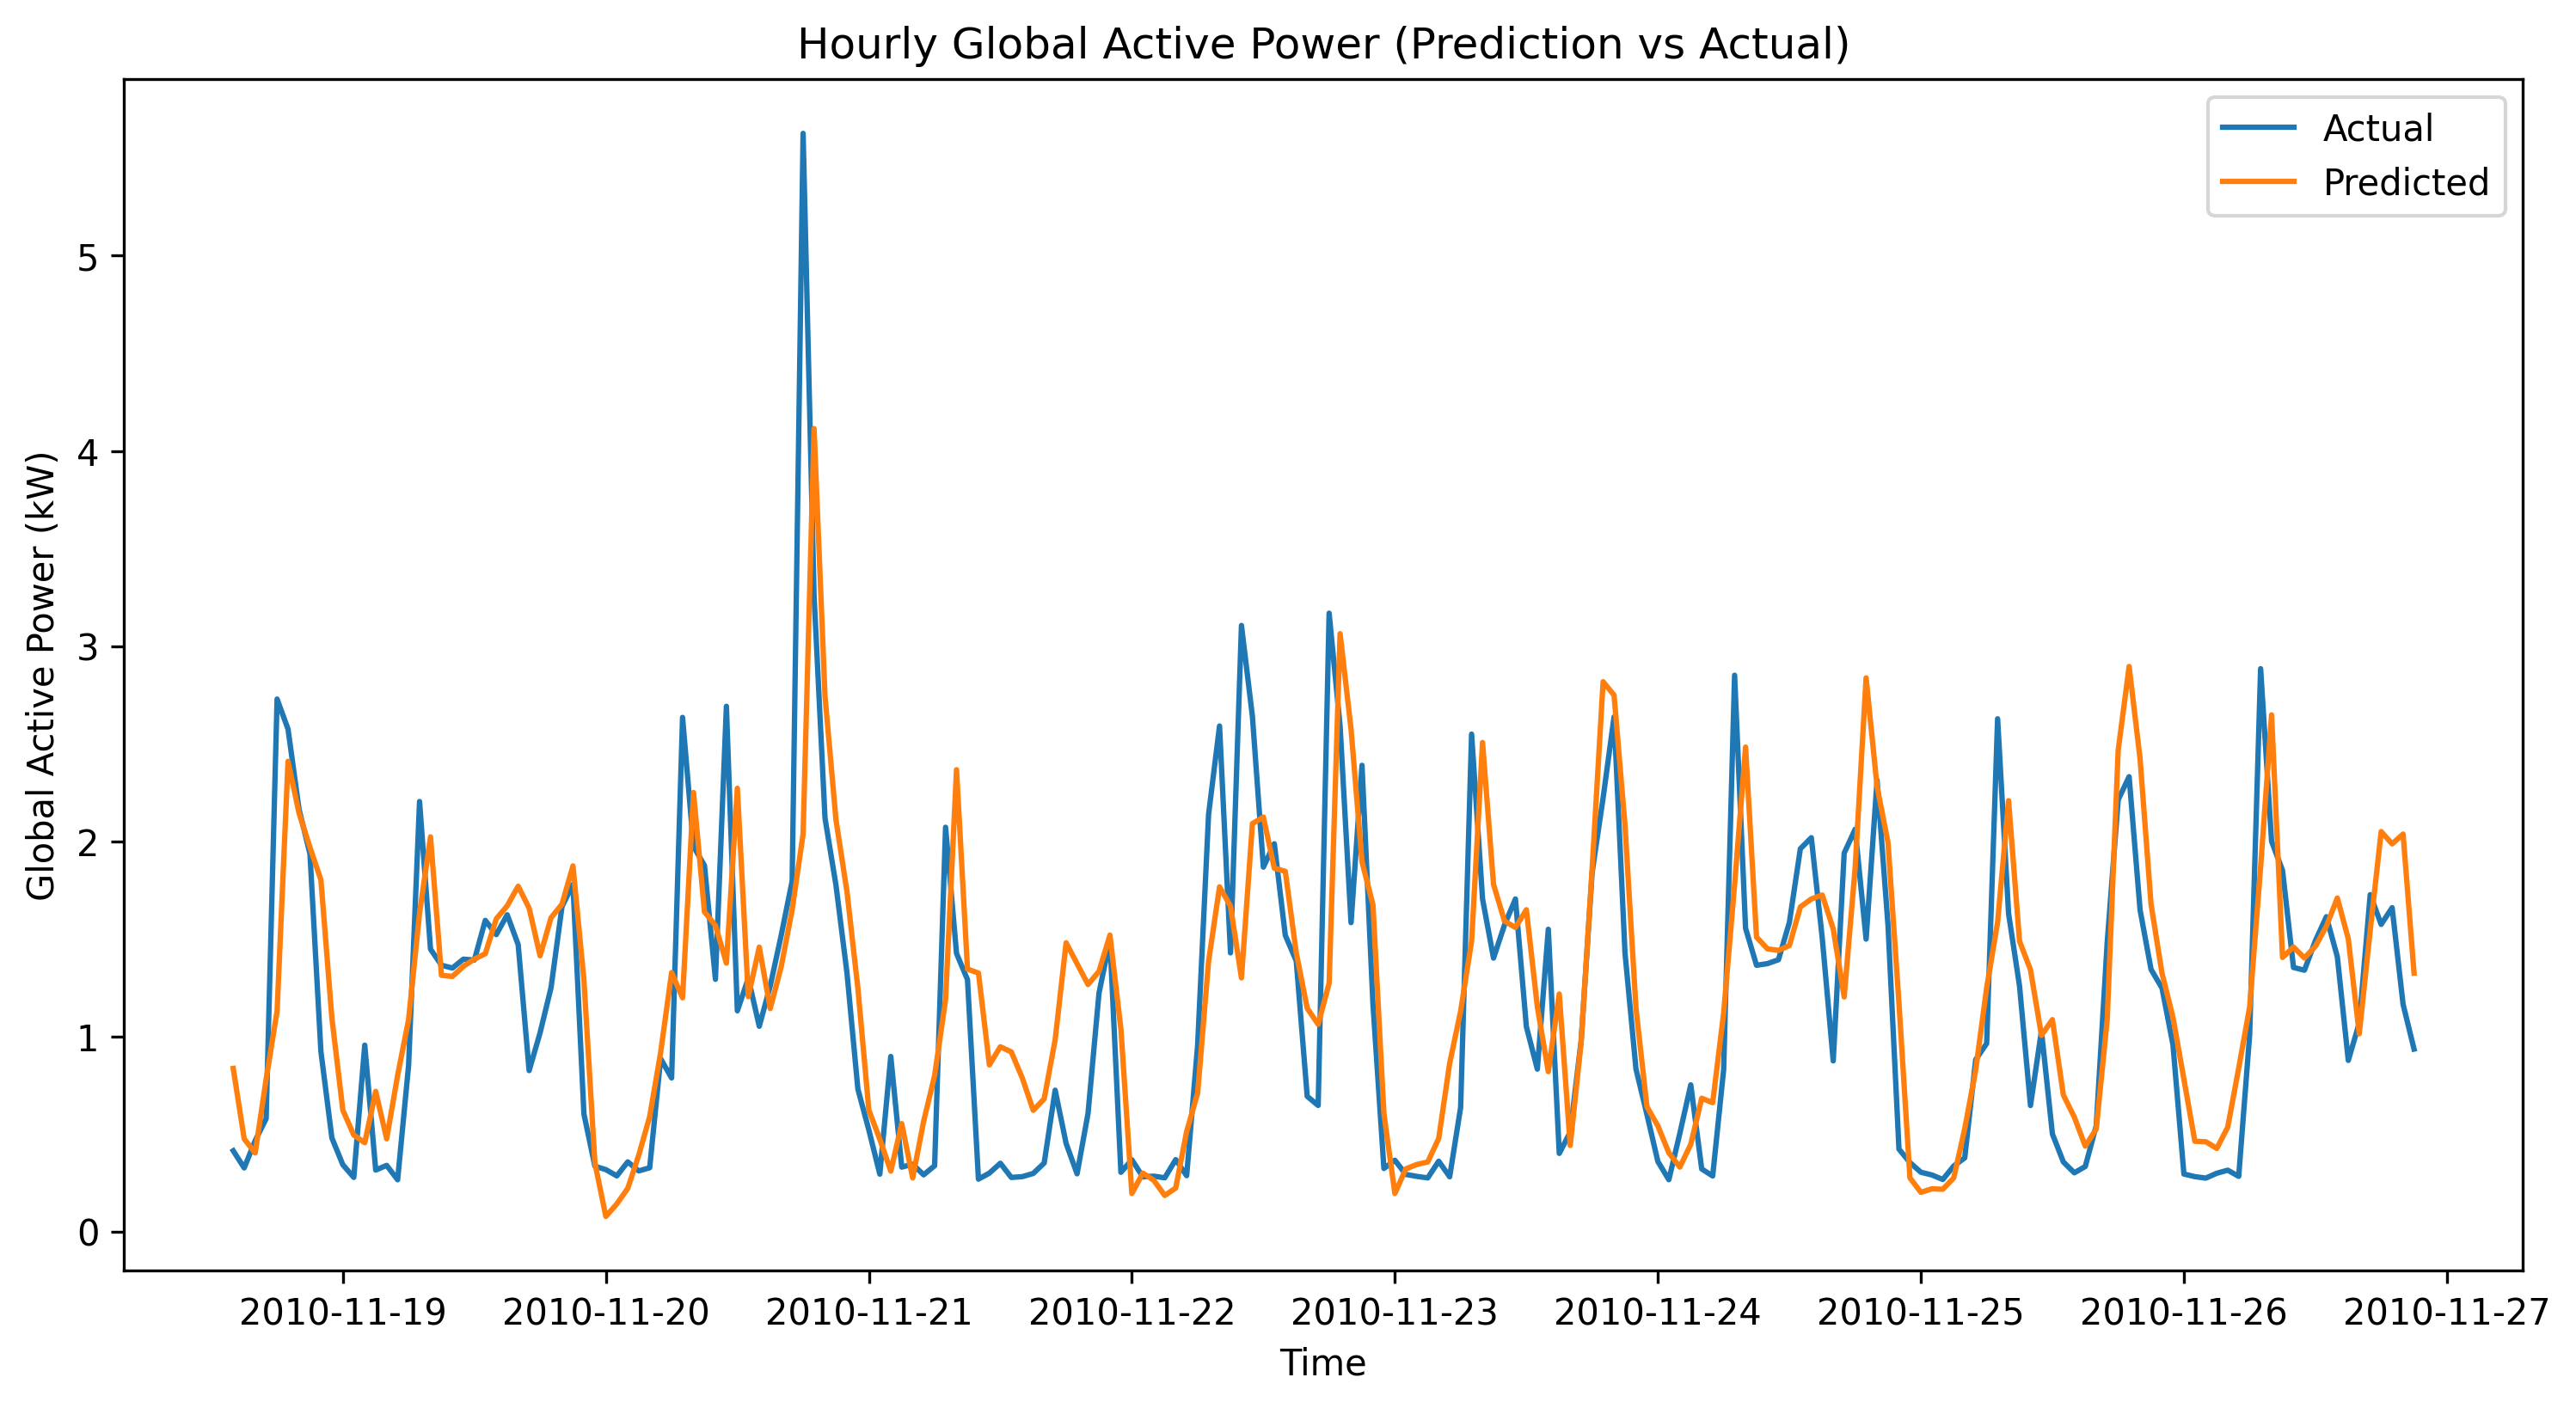

In [ ]:
# Define sequence length and features
sequence_length = 24             # Number of time steps to consider in each sequence
num_features = len(df1.columns)  # Number of features

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_df1) - sequence_length):
    seq = scaled_df1[i:i+sequence_length]
    label = scaled_df1[i+sequence_length][0]  # 'Global_Active_Power' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.80 * len(sequences))
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

# Check the shape of Train & Test Split
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# Create the LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))

# See the summary of model
model.summary()

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

# Fit the model
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test),
                    verbose=2, shuffle=False)

# Plot the training and validation loss (MSE)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

# Predict train and test data using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
y_train_copies = np.repeat(y_train.reshape(-1, 1), X_train.shape[-1], axis=-1)
true_y_train = scaler.inverse_transform(y_train_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict, df1.shape[1], axis=-1)
pred_y_train = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
y_test_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
true_y_test = scaler.inverse_transform(y_test_copies)[:,0]

# predicted values for test data
test_prediction_copies = np.repeat(test_predict, df1.shape[1], axis=-1)
pred_y_test = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print(f'\nTrain MAE: {mean_absolute_error(true_y_train, pred_y_train):.3f}')
print(f'Train MAPE: {mean_absolute_percentage_error(true_y_train, pred_y_train):.3f}')
print(f'Train MSE: {mean_squared_error(true_y_train, pred_y_train):.3f}')
print(f'Train RMSE: {np.sqrt(mean_squared_error(true_y_train, pred_y_train)):.3f}')

print(f'\nTest MAE: {mean_absolute_error(true_y_test, pred_y_test):.3f}')
print(f'Test MAPE: {mean_absolute_percentage_error(true_y_train, pred_y_train):.3f}')
print(f'Test MSE: {mean_squared_error(true_y_test, pred_y_test):.3f}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(true_y_test, pred_y_test)):.3f}')

# Plotting Hourly Global Active Power (Prediction vs Actual)
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df1.index[-200:], true_y_test[-200:], label='Actual')
plt.plot(df1.index[-200:], pred_y_test[-200:], label='Predicted')
plt.title('Hourly Global Active Power (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

## LSTM model-3 Adam(learning_rate=0.001, epochs=100, batch_size=128)

(27652, 24, 6) (27652,) (6913, 24, 6) (6913,)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                        │ (None, 100)                 │          42,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,901 (167.58 KB)

 Trainable params: 42,901 (167.58 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
217/217 - 4s - 17ms/step - loss: 0.0219 - val_loss: 0.0120
Epoch 2/100
217/217 - 4s - 17ms/step - loss: 0.0174 - val_loss: 0.0106
Epoch 3/100
217/217 - 1s - 5ms/step - loss: 0.0157 - val_loss: 0.0097
Epoch 4/100
217/217 - 1s - 6ms/step - loss: 0.0145 - val_loss: 0.0091
Epoch 5/100
217/217 - 1s - 5ms/step - loss: 0.0135 - val_loss: 0.0086
Epoch 6/100
217/217 - 1s - 6ms/step - loss: 0.0127 - val_loss: 0.0083
Epoch 7/100
217/217 - 1s - 6ms/step - loss: 0.0121 - val_loss: 0.0081
Epoch 8/100
217/217 - 1s - 6ms/step - loss: 0.0116 - val_loss: 0.0079
Epoch 9/100
217/217 - 2s - 8ms/step - loss: 0.0113 - val_loss: 0.0078
Epoch 10/100
217/217 - 2s - 11ms/step - loss: 0.0110 - val_loss: 0.0078
Epoch 11/100
217/217 - 1s - 5ms/step - loss: 0.0108 - val_loss: 0.0076
Epoch 12/100
217/217 - 1s - 6ms/step - loss: 0.0107 - val_loss: 0.0075
Epoch 13/100
217/217 - 1s - 6ms/step - loss: 0.0105 - val_loss: 0.0074
Epoch 14/100
217/217 - 1s - 5ms/step - loss: 0.0104 - val_loss: 0.0073
Epoch 15/100

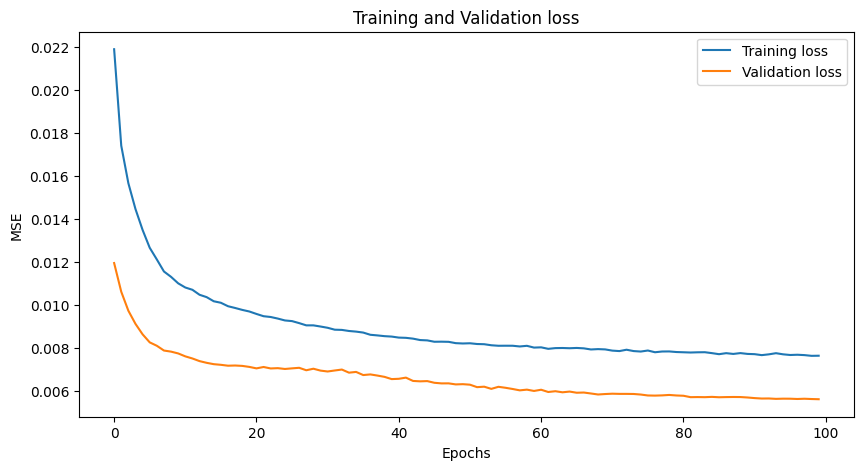

865/865 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Train MAE: 0.397
Train MAPE: 0.570
Train MSE: 0.310
Train RMSE: 0.557

Test MAE: 0.350
Test MAPE: 0.570
Test MSE: 0.233
Test RMSE: 0.483


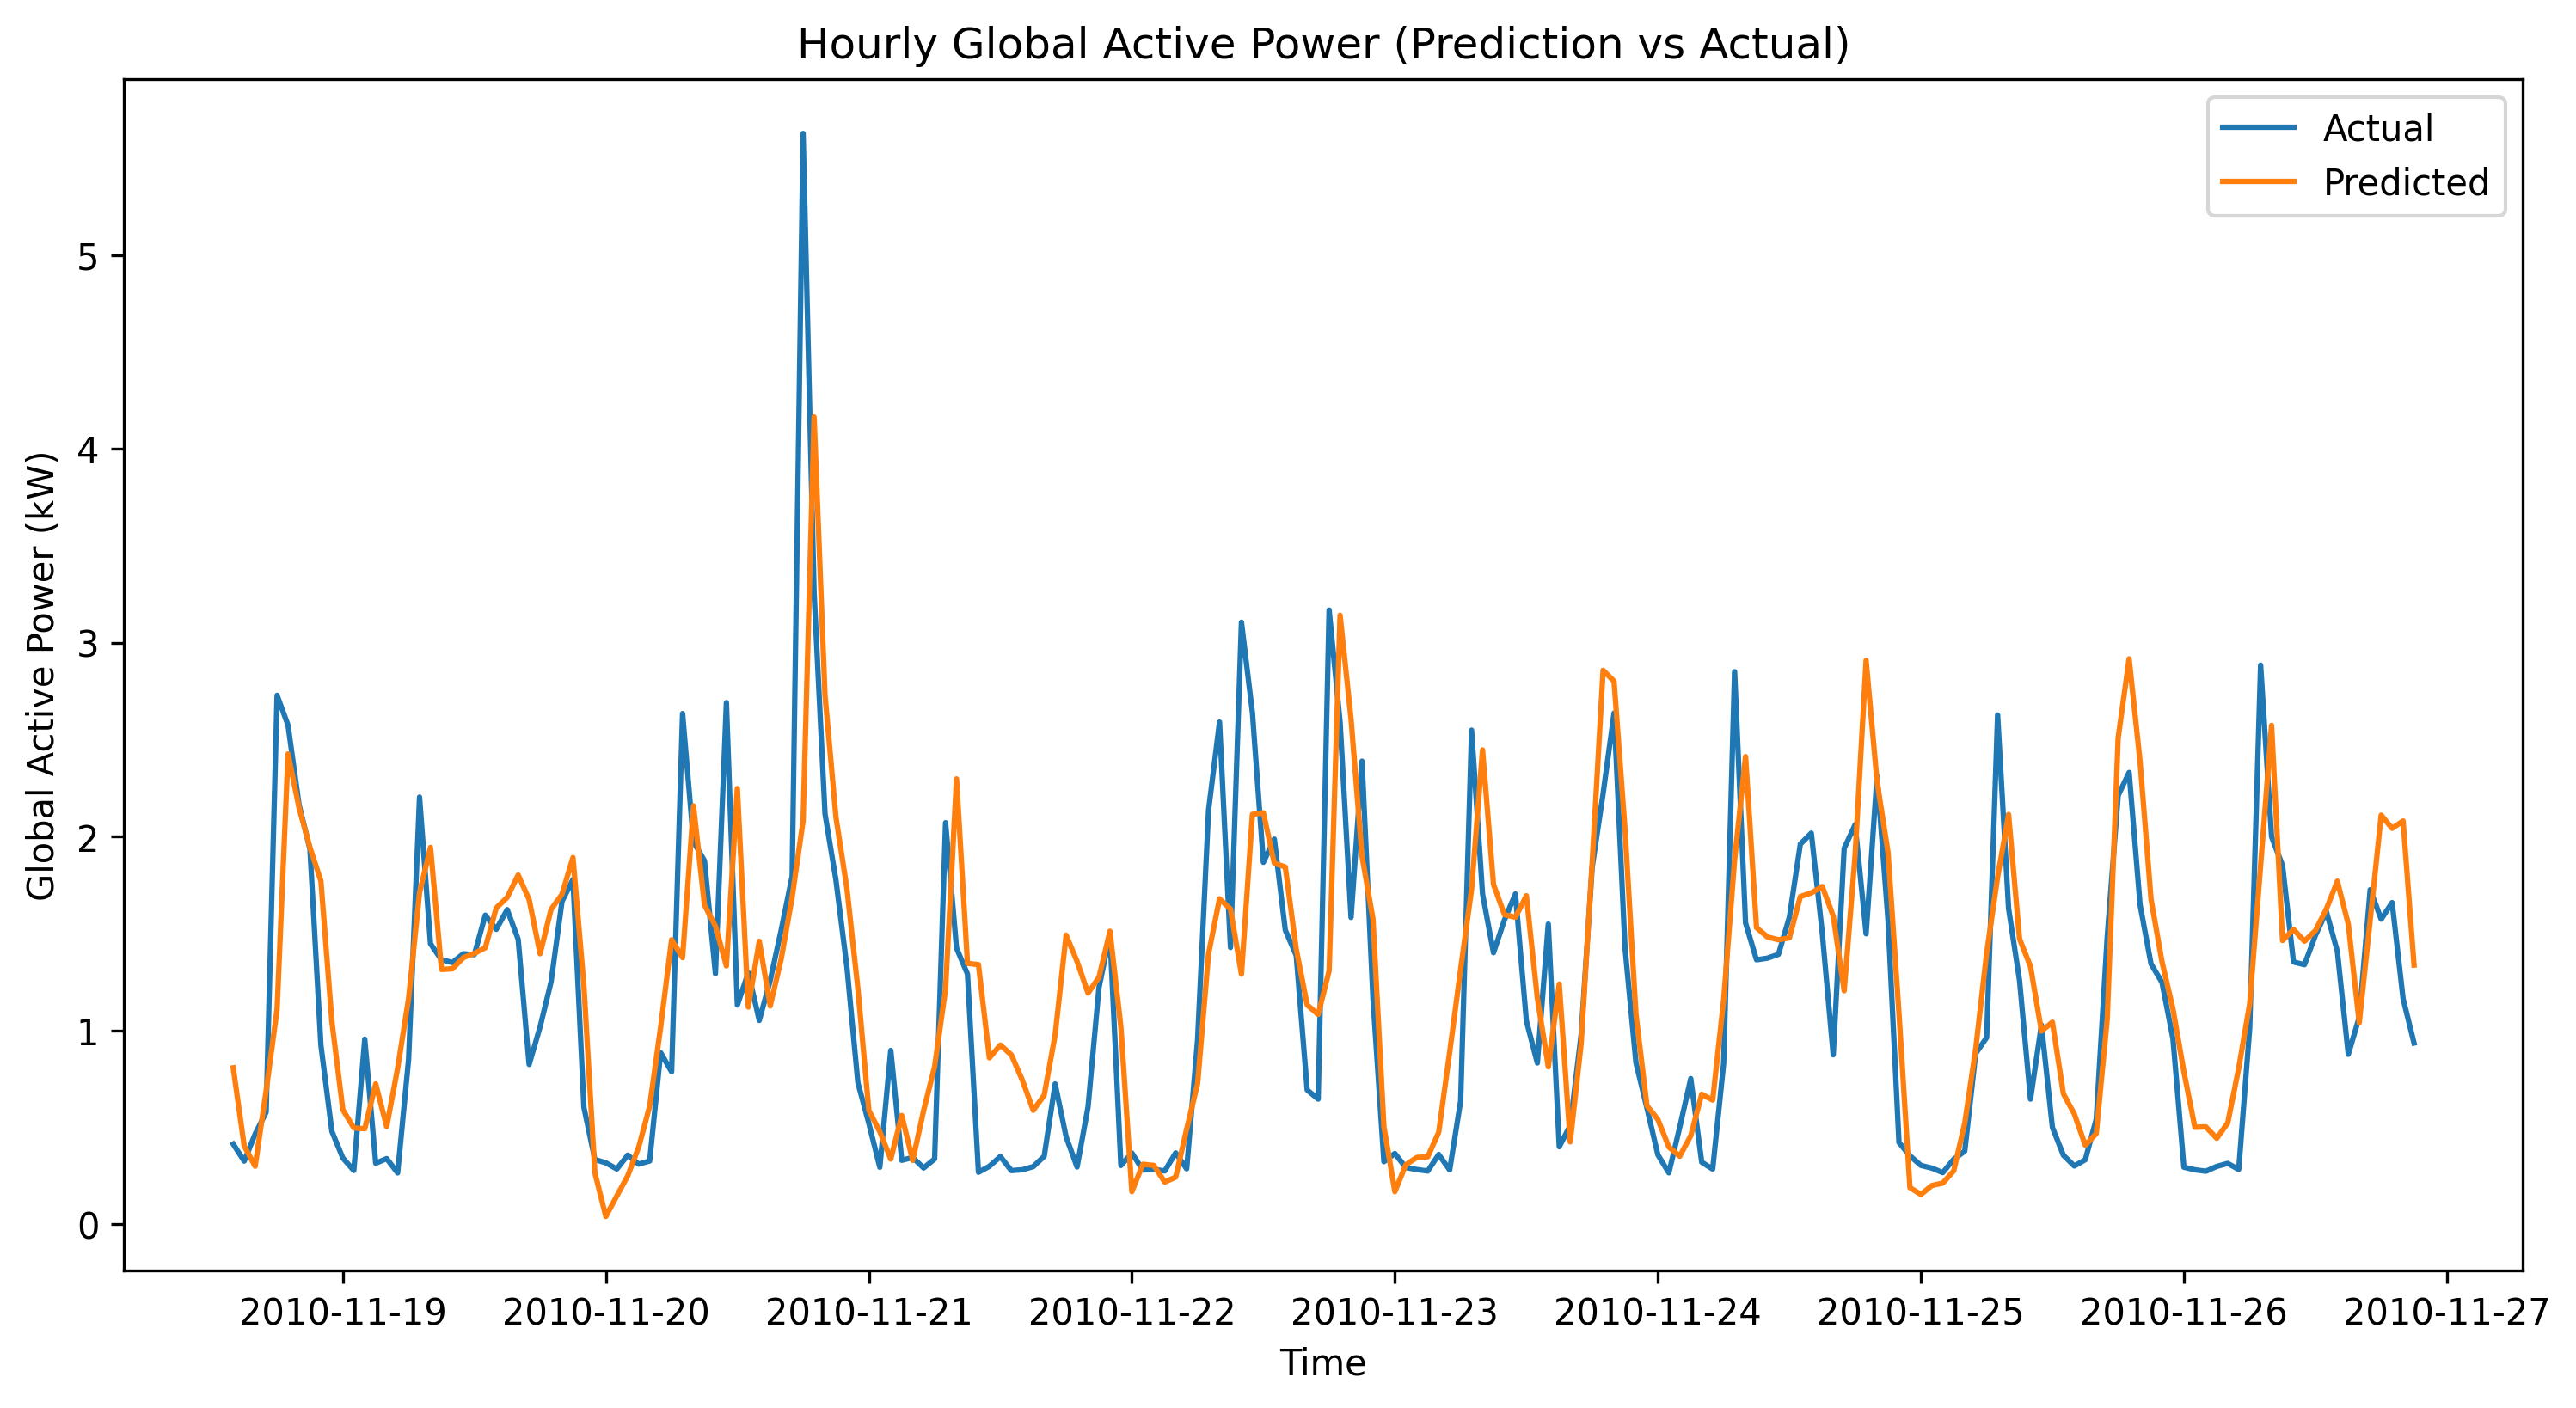

In [ ]:
# Define sequence length and features
sequence_length = 24             # Number of time steps to consider in each sequence
num_features = len(df1.columns)  # Number of features

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_df1) - sequence_length):
    seq = scaled_df1[i:i+sequence_length]
    label = scaled_df1[i+sequence_length][0]  # 'Global_Active_Power' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.80 * len(sequences))
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

# Check the shape of Train & Test Split
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# Create the LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))

# See the summary of model
model.summary()

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

# Fit the model
history = model.fit(X_train, y_train, epochs=100, batch_size=128, validation_data=(X_test, y_test),
                    verbose=2, shuffle=False)

# Plot the training and validation loss (MSE)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

# Predict train and test data using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
y_train_copies = np.repeat(y_train.reshape(-1, 1), X_train.shape[-1], axis=-1)
true_y_train = scaler.inverse_transform(y_train_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict, df1.shape[1], axis=-1)
pred_y_train = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
y_test_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
true_y_test = scaler.inverse_transform(y_test_copies)[:,0]

# predicted values for test data
test_prediction_copies = np.repeat(test_predict, df1.shape[1], axis=-1)
pred_y_test = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print(f'\nTrain MAE: {mean_absolute_error(true_y_train, pred_y_train):.3f}')
print(f'Train MAPE: {mean_absolute_percentage_error(true_y_train, pred_y_train):.3f}')
print(f'Train MSE: {mean_squared_error(true_y_train, pred_y_train):.3f}')
print(f'Train RMSE: {np.sqrt(mean_squared_error(true_y_train, pred_y_train)):.3f}')

print(f'\nTest MAE: {mean_absolute_error(true_y_test, pred_y_test):.3f}')
print(f'Test MAPE: {mean_absolute_percentage_error(true_y_train, pred_y_train):.3f}')
print(f'Test MSE: {mean_squared_error(true_y_test, pred_y_test):.3f}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(true_y_test, pred_y_test)):.3f}')

# Plotting Hourly Global Active Power (Prediction vs Actual)
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df1.index[-200:], true_y_test[-200:], label='Actual')
plt.plot(df1.index[-200:], pred_y_test[-200:], label='Predicted')
plt.title('Hourly Global Active Power (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

## LSTM model-4 Adam(learning_rate=0.001, epochs=200, batch_size=256)

(27652, 24, 6) (27652,) (6913, 24, 6) (6913,)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 100)                 │          42,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,901 (167.58 KB)

 Trainable params: 42,901 (167.58 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
109/109 - 2s - 18ms/step - loss: 0.0257 - val_loss: 0.0113
Epoch 2/200
109/109 - 1s - 9ms/step - loss: 0.0188 - val_loss: 0.0103
Epoch 3/200
109/109 - 1s - 5ms/step - loss: 0.0173 - val_loss: 0.0097
Epoch 4/200
109/109 - 1s - 6ms/step - loss: 0.0164 - val_loss: 0.0092
Epoch 5/200
109/109 - 1s - 6ms/step - loss: 0.0155 - val_loss: 0.0089
Epoch 6/200
109/109 - 1s - 6ms/step - loss: 0.0147 - val_loss: 0.0086
Epoch 7/200
109/109 - 1s - 5ms/step - loss: 0.0142 - val_loss: 0.0084
Epoch 8/200
109/109 - 1s - 5ms/step - loss: 0.0135 - val_loss: 0.0082
Epoch 9/200
109/109 - 1s - 8ms/step - loss: 0.0131 - val_loss: 0.0081
Epoch 10/200
109/109 - 1s - 7ms/step - loss: 0.0127 - val_loss: 0.0079
Epoch 11/200
109/109 - 1s - 7ms/step - loss: 0.0124 - val_loss: 0.0077
Epoch 12/200
109/109 - 1s - 8ms/step - loss: 0.0121 - val_loss: 0.0076
Epoch 13/200
109/109 - 1s - 12ms/step - loss: 0.0117 - val_loss: 0.0075
Epoch 14/200
109/109 - 1s - 9ms/step - loss: 0.0115 - val_loss: 0.0075
Epoch 15/200


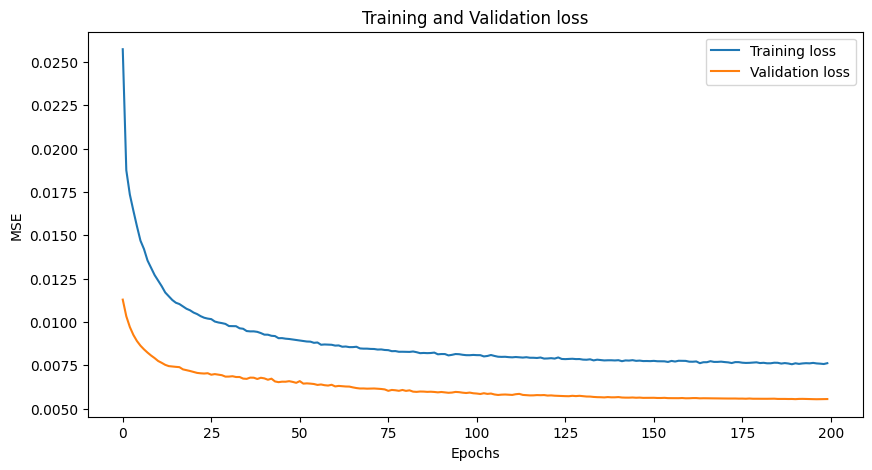

865/865 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Train MAE: 0.380
Train MAPE: 0.497
Train MSE: 0.304
Train RMSE: 0.552

Test MAE: 0.336
Test MAPE: 0.497
Test MSE: 0.230
Test RMSE: 0.480


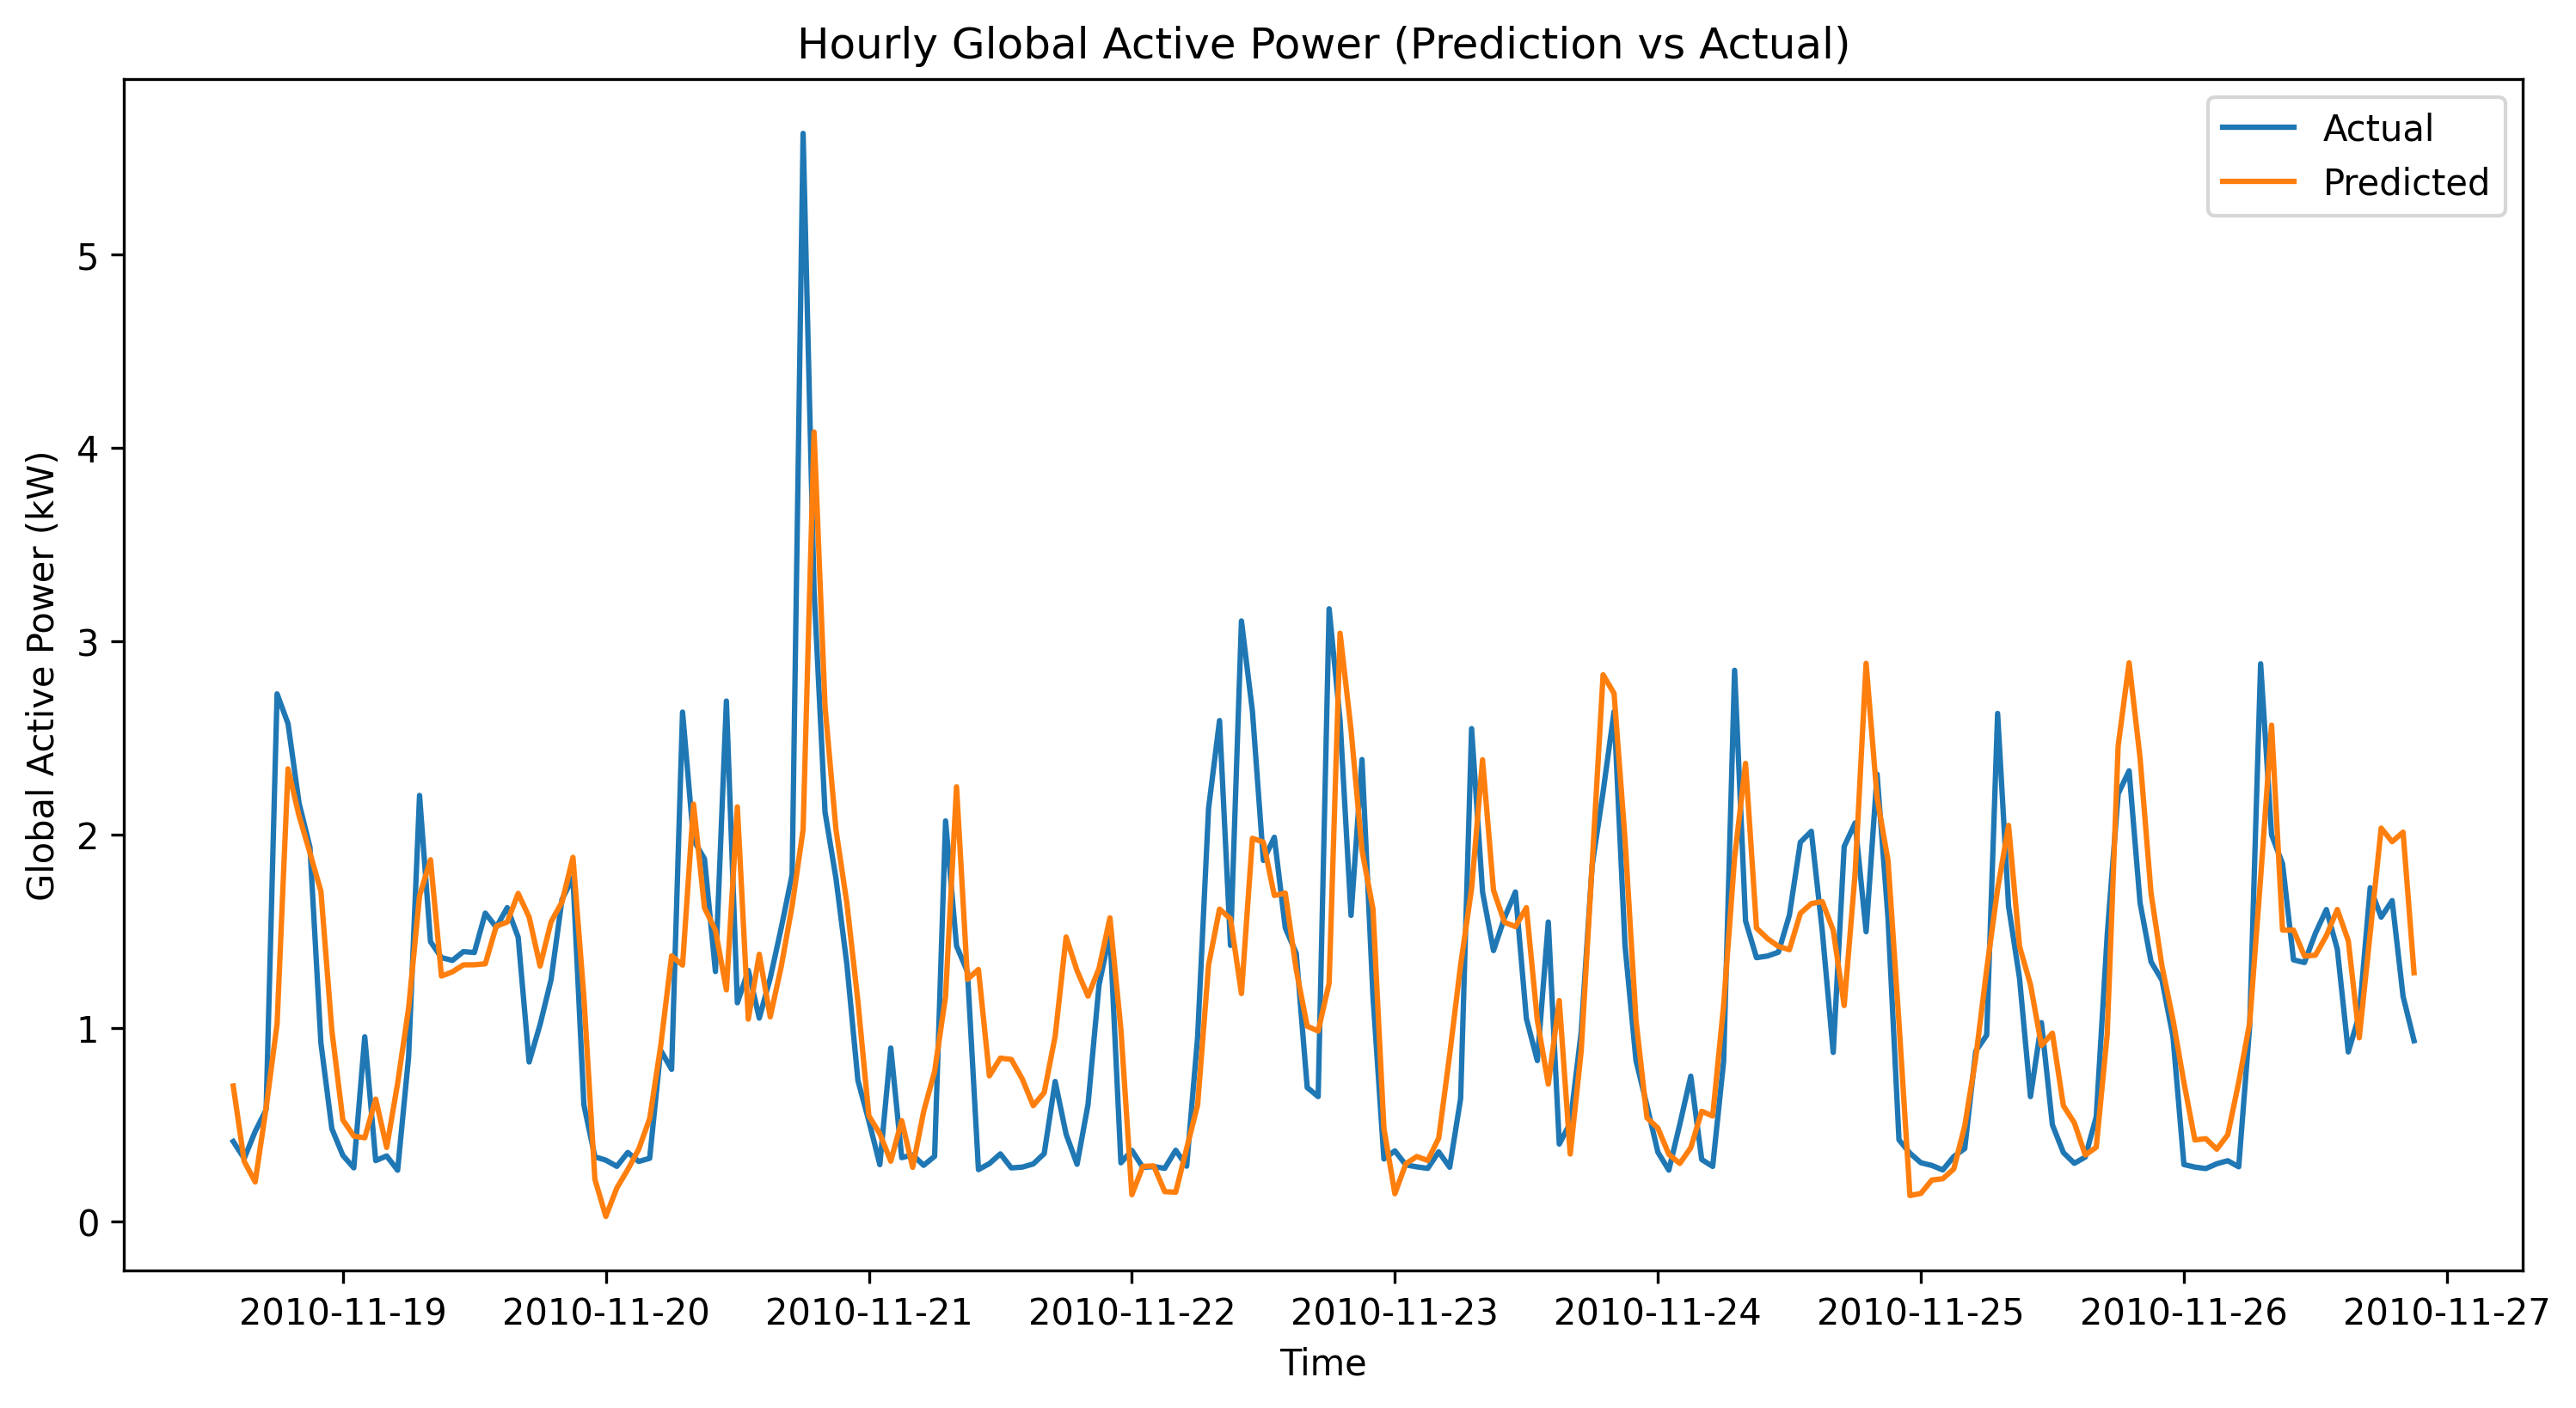

In [ ]:
# Define sequence length and features
sequence_length = 24             # Number of time steps to consider in each sequence
num_features = len(df1.columns)  # Number of features

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_df1) - sequence_length):
    seq = scaled_df1[i:i+sequence_length]
    label = scaled_df1[i+sequence_length][0]  # 'Global_Active_Power' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.80 * len(sequences))
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

# Check the shape of Train & Test Split
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# Create the LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))

# See the summary of model
model.summary()

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

# Fit the model
history = model.fit(X_train, y_train, epochs=200, batch_size=256, validation_data=(X_test, y_test),
                    verbose=2, shuffle=False)

# Plot the training and validation loss (MSE)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

# Predict train and test data using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
y_train_copies = np.repeat(y_train.reshape(-1, 1), X_train.shape[-1], axis=-1)
true_y_train = scaler.inverse_transform(y_train_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict, df1.shape[1], axis=-1)
pred_y_train = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
y_test_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
true_y_test = scaler.inverse_transform(y_test_copies)[:,0]

# predicted values for test data
test_prediction_copies = np.repeat(test_predict, df1.shape[1], axis=-1)
pred_y_test = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print(f'\nTrain MAE: {mean_absolute_error(true_y_train, pred_y_train):.3f}')
print(f'Train MAPE: {mean_absolute_percentage_error(true_y_train, pred_y_train):.3f}')
print(f'Train MSE: {mean_squared_error(true_y_train, pred_y_train):.3f}')
print(f'Train RMSE: {np.sqrt(mean_squared_error(true_y_train, pred_y_train)):.3f}')

print(f'\nTest MAE: {mean_absolute_error(true_y_test, pred_y_test):.3f}')
print(f'Test MAPE: {mean_absolute_percentage_error(true_y_train, pred_y_train):.3f}')
print(f'Test MSE: {mean_squared_error(true_y_test, pred_y_test):.3f}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(true_y_test, pred_y_test)):.3f}')

# Plotting Hourly Global Active Power (Prediction vs Actual)
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df1.index[-200:], true_y_test[-200:], label='Actual')
plt.plot(df1.index[-200:], pred_y_test[-200:], label='Predicted')
plt.title('Hourly Global Active Power (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

# Daily resampled data

In [ ]:
# Resampled the data
daily_resampled = df_imputed.resample('D').mean()

# Save the data
daily_resampled.to_csv('daily_resampled.csv')

## EDA

Shape after Daily resampling of data : (1442, 8) 




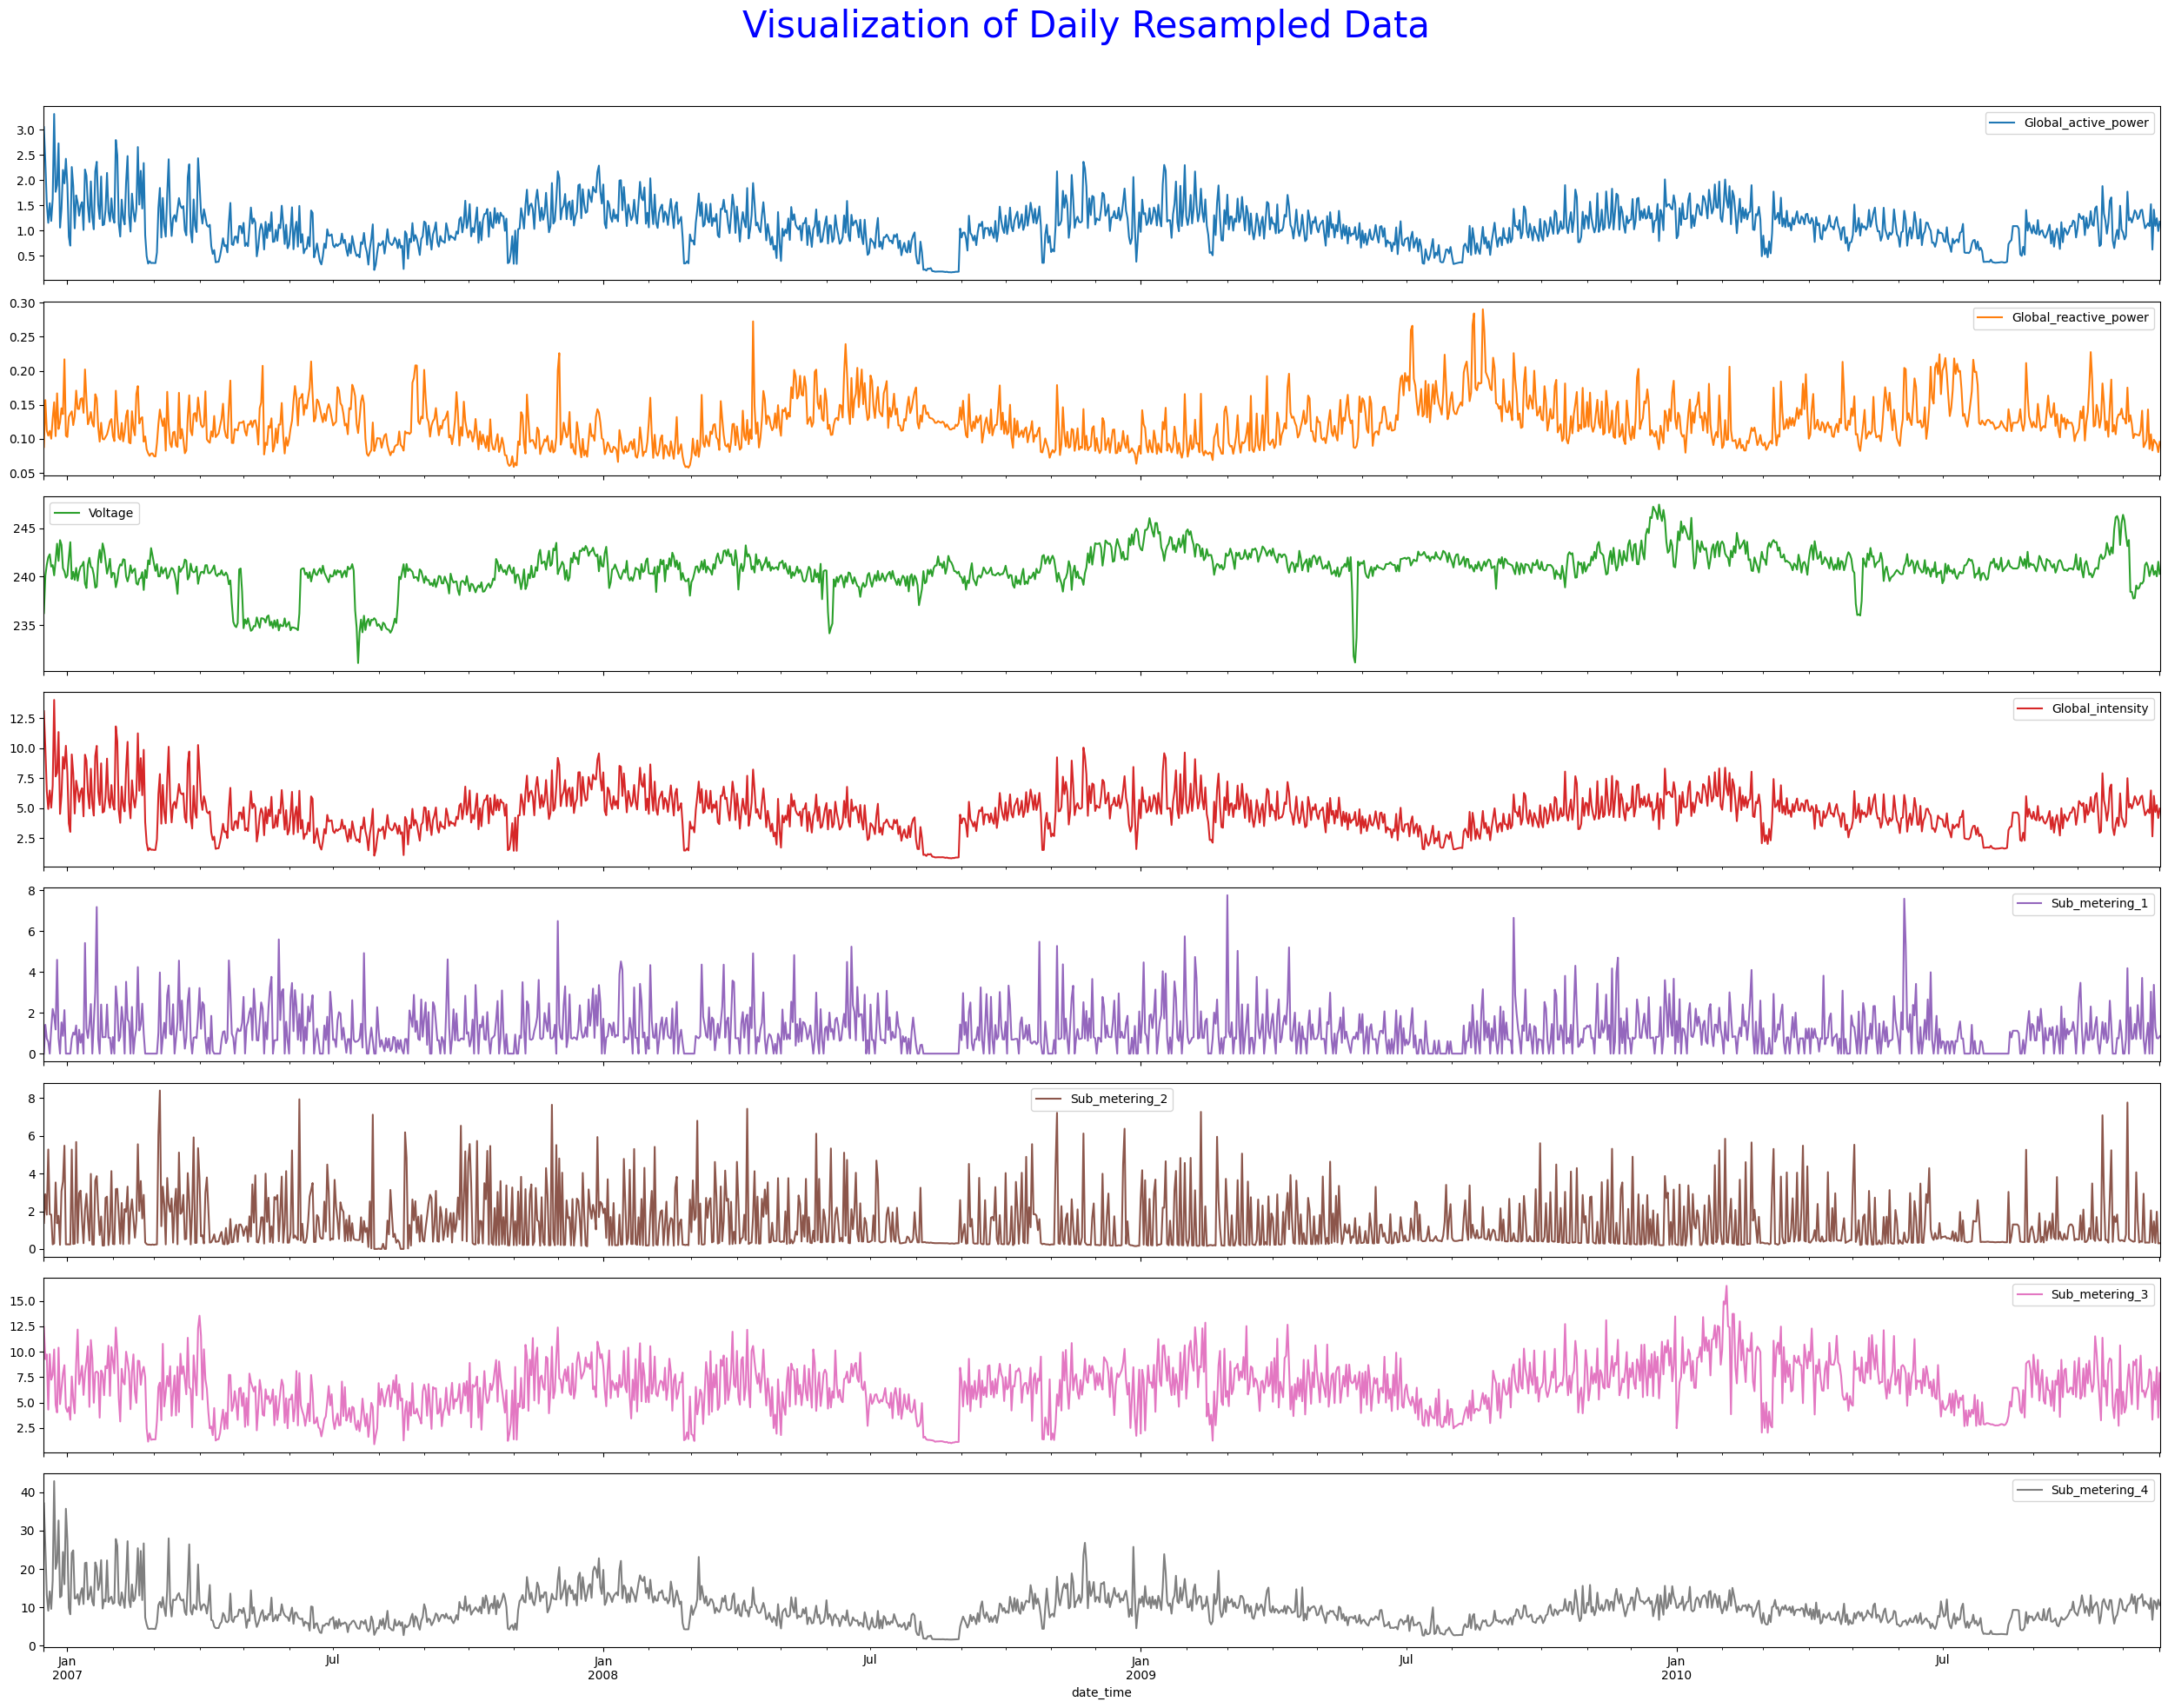

 

************************************************ Distribution Plot for Daily Resampled Data **************************************************



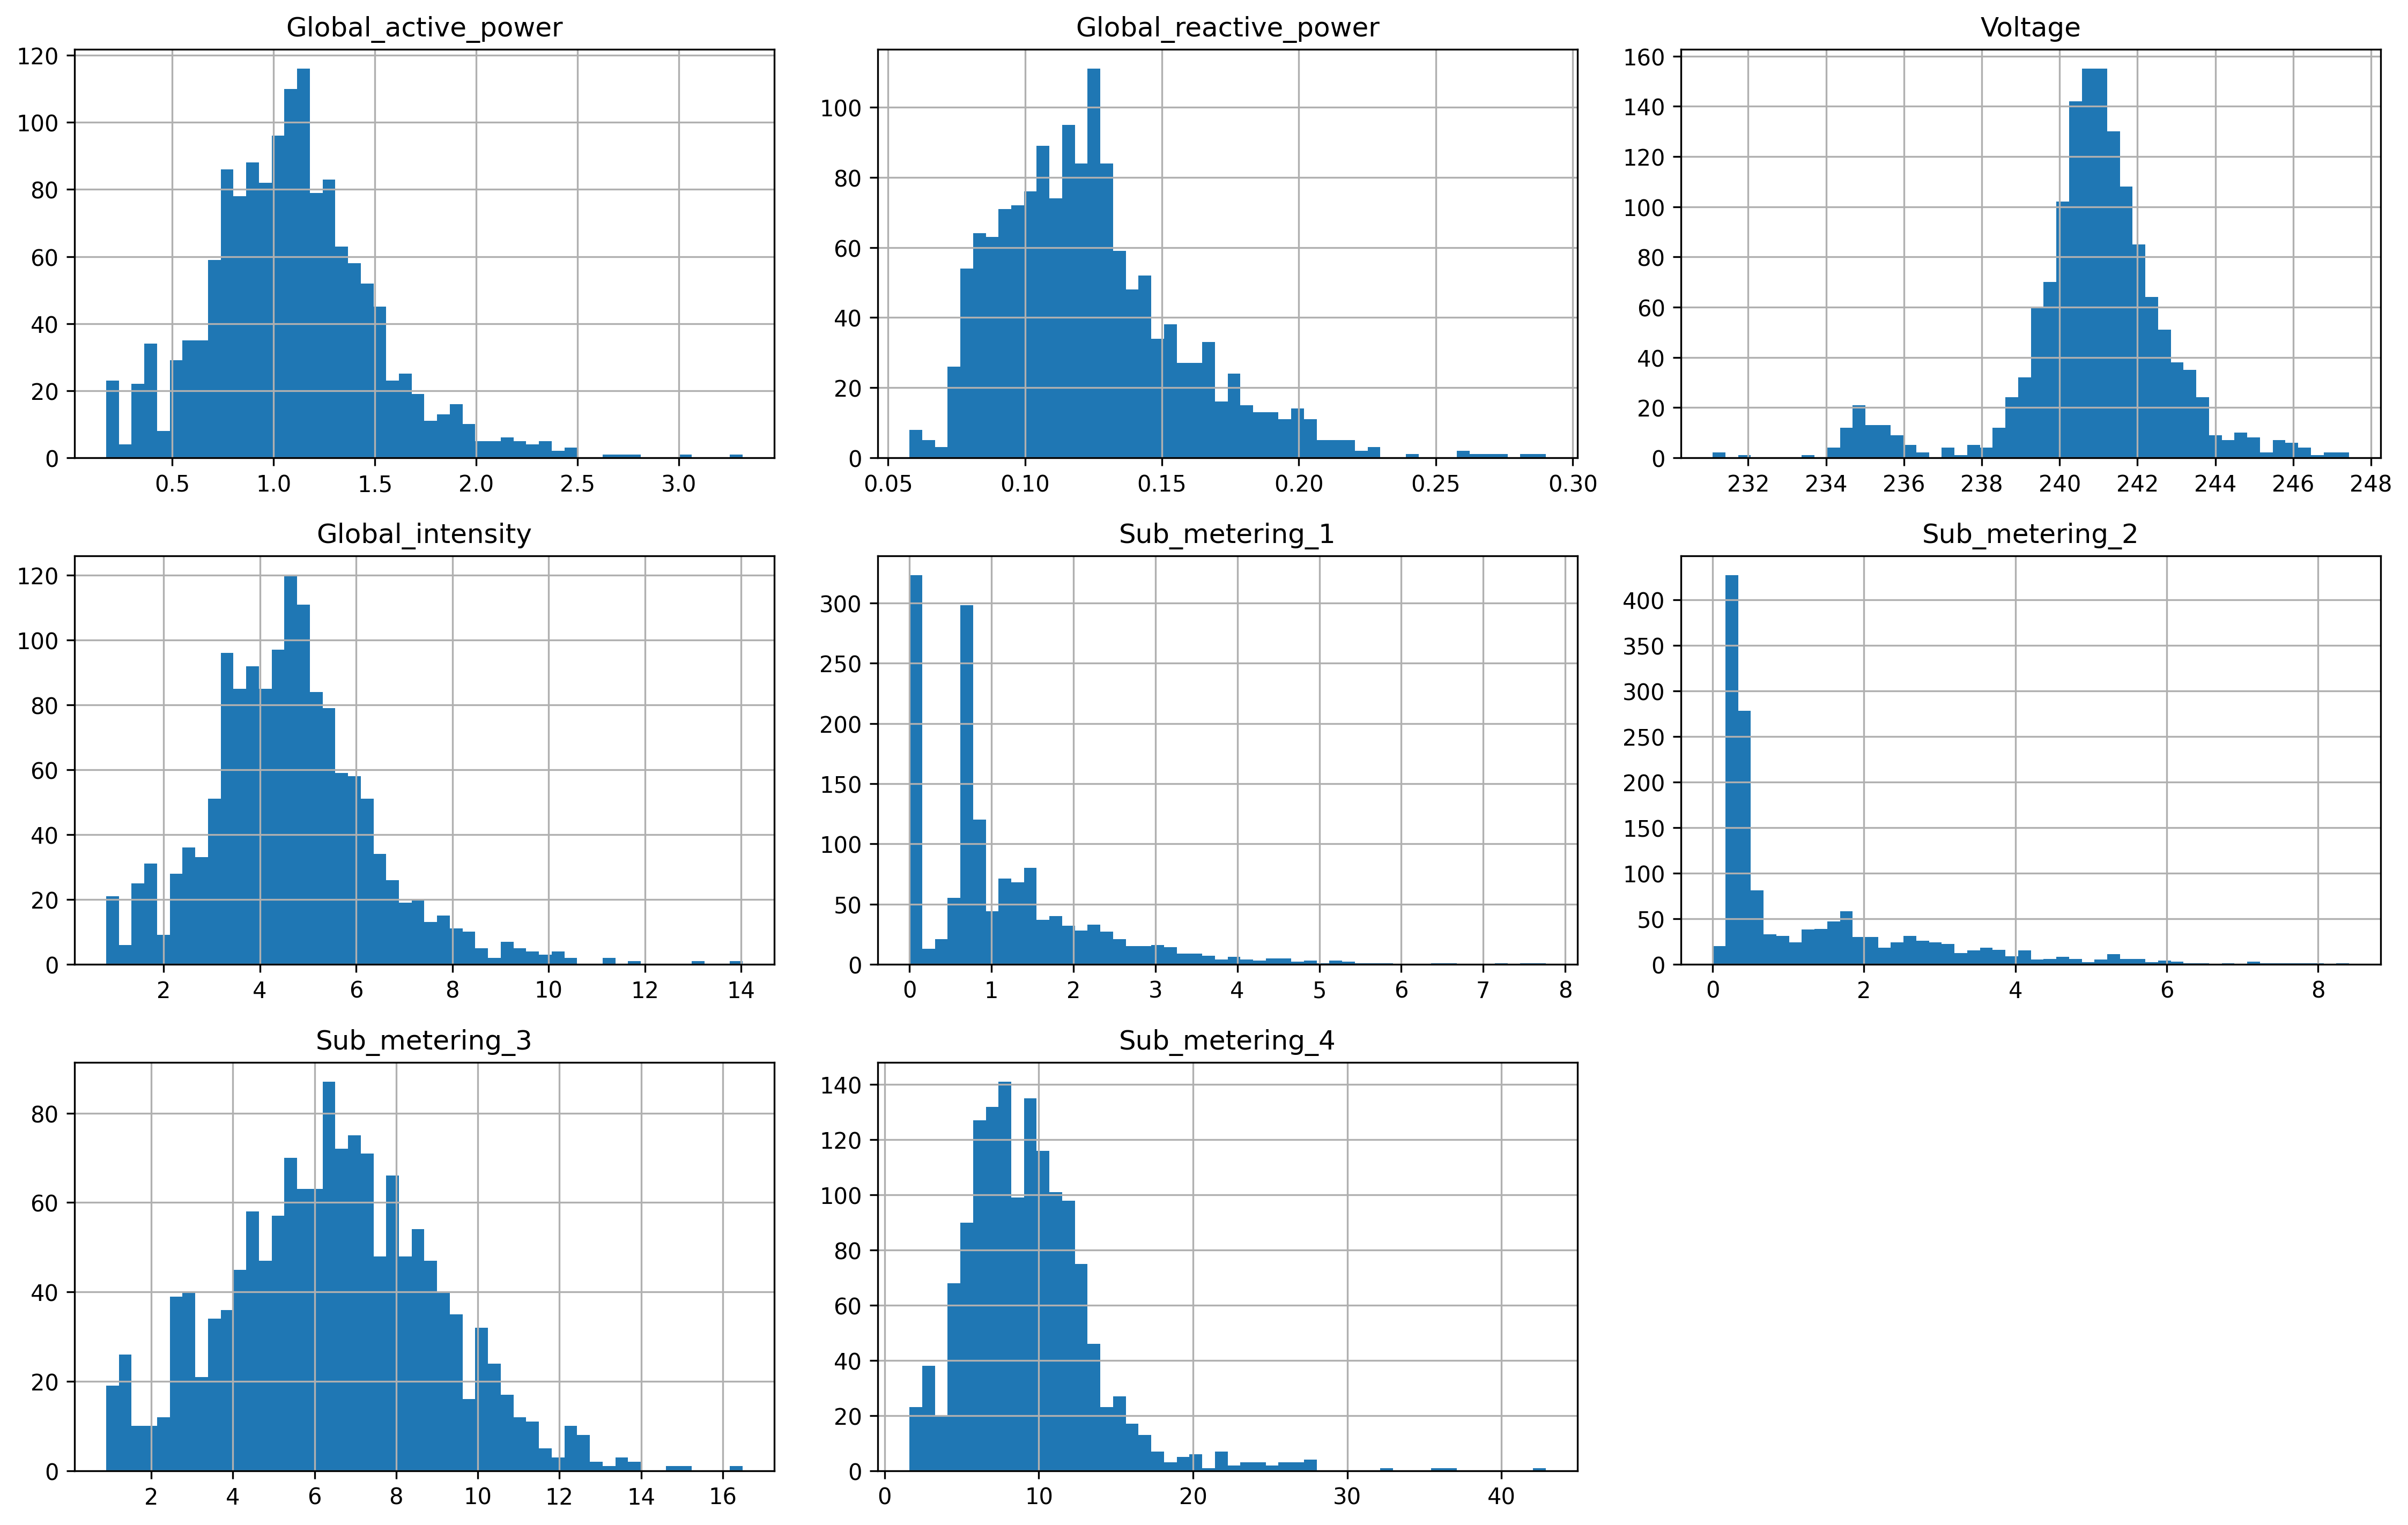

 

************************************************ Correlation Plot for Daily Resampled Data **************************************************



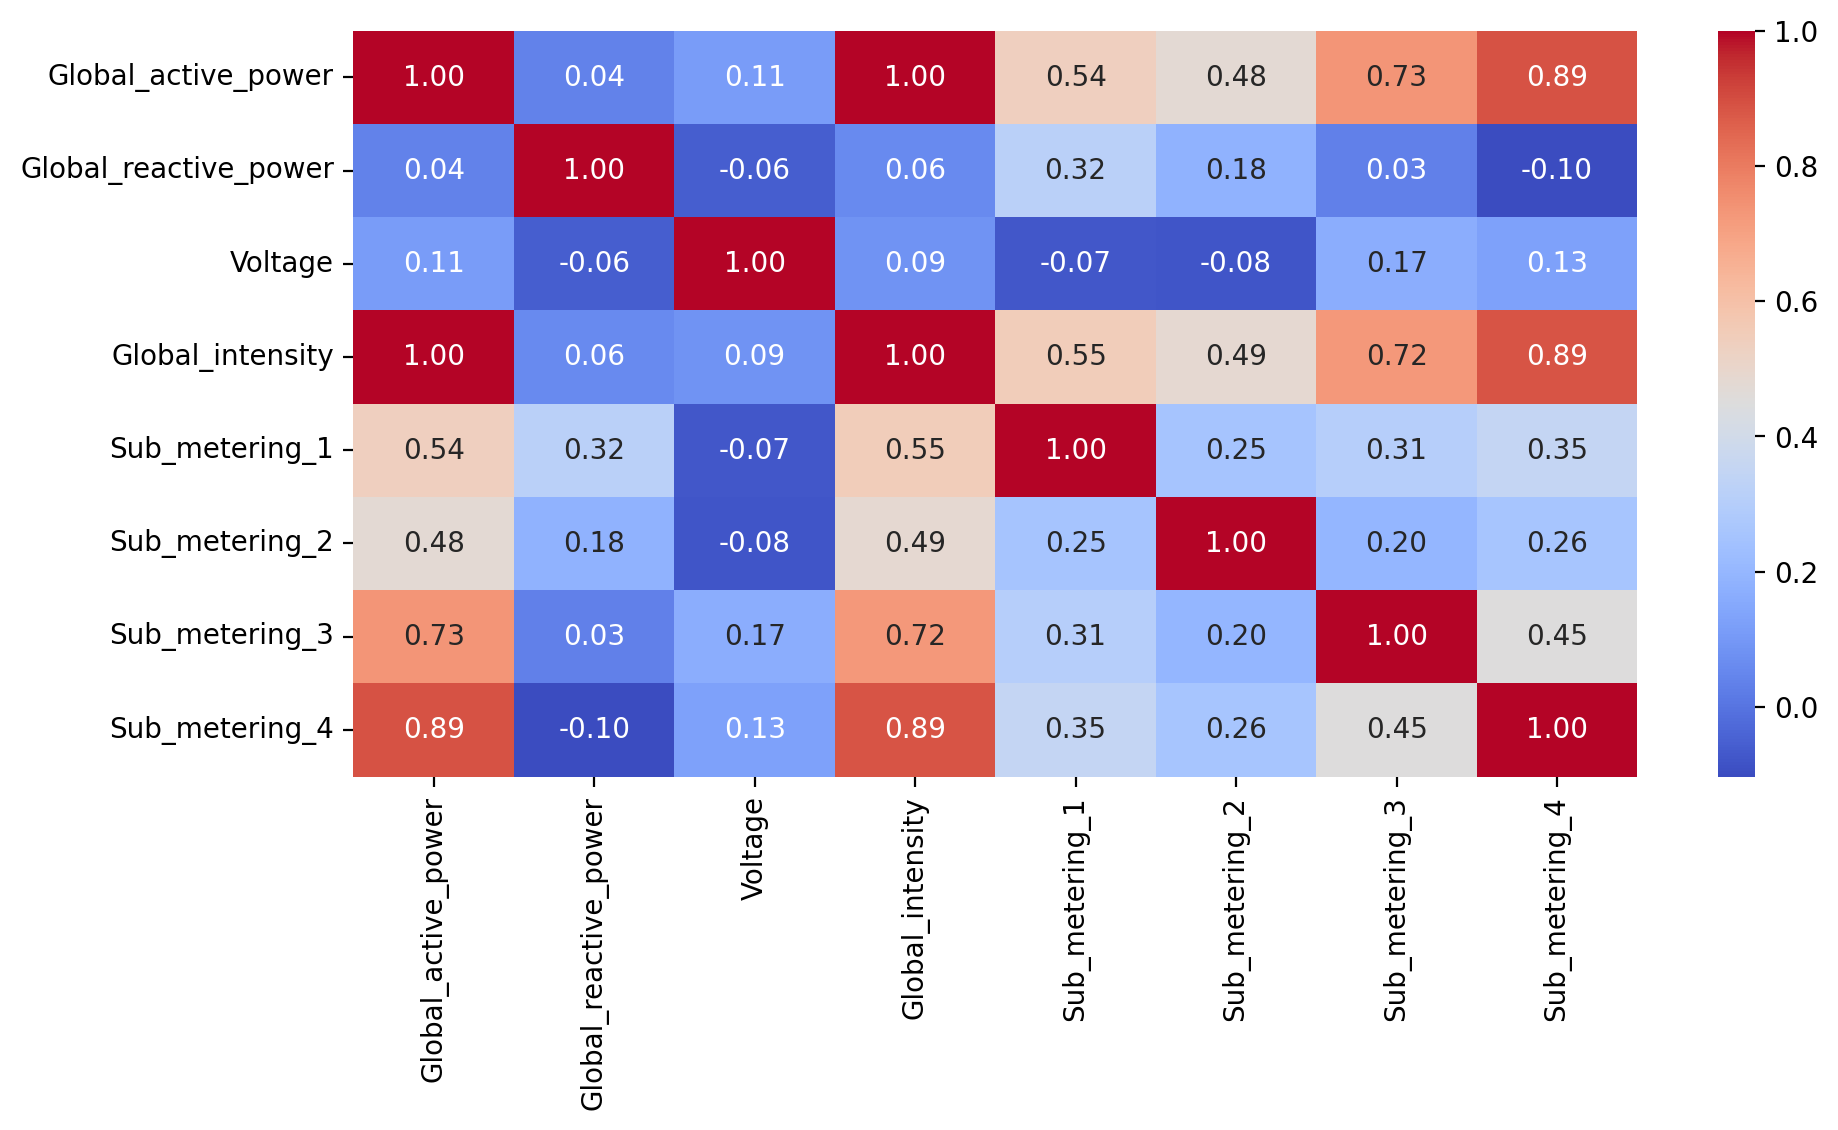

In [ ]:
# Plot the visualization, distribution and correlation of Hourly resampled data
df_visu_dist_corr(df_imputed, "D", "Daily")

In [ ]:
# Remove higly correlated columns
df2 = daily_resampled.drop(['Global_intensity','Sub_metering_4'], axis=1)
df2

Global_active_power  Global_reactive_power     Voltage  \
date_time                                                            
2006-12-16             3.053475               0.088187  236.243763   
2006-12-17             2.354486               0.156949  240.087028   
2006-12-18             1.530435               0.112356  241.231694   
2006-12-19             1.157079               0.104821  241.999313   
2006-12-20             1.545658               0.111804  242.308062   
...                         ...                    ...         ...   
2010-11-22             1.417733               0.098857  240.197118   
2010-11-23             1.095511               0.095451  240.575528   
2010-11-24             1.247394               0.091986  240.030965   
2010-11-25             0.993864               0.080644  241.536257   
2010-11-26             1.178230               0.095666  240.291029   

            Sub_metering_1  Sub_metering_2  Sub_metering_3  
date_time                                                   
2006-12-16        0.000000        1.378788       12.439394  
2006-12-17        1.411806        2.907639        9.264583  
2006-12-18        0.738194        1.820139        9.734722  
2006-12-19        0.582639        5.279167        4.303472  
2006-12-20        0.000000        1.838889        9.765972  
...                    ...             ...             ...  
2010-11-22        3.371528        1.465278        7.038889  
2010-11-23        1.299306        0.318056        5.285417  
2010-11-24        0.761111        1.977778        8.488889  
2010-11-25        0.747222        0.295833        3.522222  
2010-11-26        0.855107        0.304830        7.908947  

[1442 rows x 6 columns]

## Data Normalization

In [ ]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df2 = scaler.fit_transform(df2)

# Shape of scaled data
scaled_df2.shape

(1442, 6)

## LSTM model-1 Adam(learning_rate=0.01, epochs=20, batch_size=32) sq=7

(1148, 7, 6) (1148,) (287, 7, 6) (287,)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 100)                 │          42,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,901 (167.58 KB)

 Trainable params: 42,901 (167.58 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
36/36 - 2s - 44ms/step - loss: 0.0300 - val_loss: 0.0067
Epoch 2/20
36/36 - 0s - 5ms/step - loss: 0.0134 - val_loss: 0.0082
Epoch 3/20
36/36 - 0s - 8ms/step - loss: 0.0128 - val_loss: 0.0087
Epoch 4/20
36/36 - 0s - 5ms/step - loss: 0.0124 - val_loss: 0.0073
Epoch 5/20
36/36 - 0s - 5ms/step - loss: 0.0120 - val_loss: 0.0079
Epoch 6/20
36/36 - 0s - 5ms/step - loss: 0.0118 - val_loss: 0.0069
Epoch 7/20
36/36 - 0s - 5ms/step - loss: 0.0113 - val_loss: 0.0075
Epoch 8/20
36/36 - 0s - 8ms/step - loss: 0.0114 - val_loss: 0.0066
Epoch 9/20
36/36 - 0s - 5ms/step - loss: 0.0107 - val_loss: 0.0077
Epoch 10/20
36/36 - 0s - 5ms/step - loss: 0.0111 - val_loss: 0.0068
Epoch 11/20
36/36 - 0s - 8ms/step - loss: 0.0106 - val_loss: 0.0068
Epoch 12/20
36/36 - 0s - 8ms/step - loss: 0.0105 - val_loss: 0.0067
Epoch 13/20
36/36 - 0s - 5ms/step - loss: 0.0104 - val_loss: 0.0081
Epoch 14/20
36/36 - 0s - 8ms/step - loss: 0.0109 - val_loss: 0.0068
Epoch 15/20
36/36 - 0s - 8ms/step - loss: 0.0106 - val_l

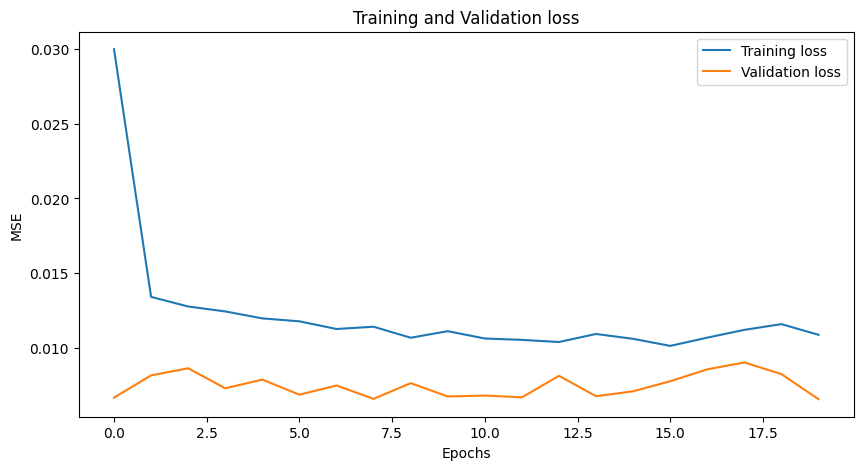

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Train MAE: 0.234
Train MAPE: 0.262
Train MSE: 0.096
Train RMSE: 0.310

Test MAE: 0.198
Test MAPE: 0.262
Test MSE: 0.065
Test RMSE: 0.255


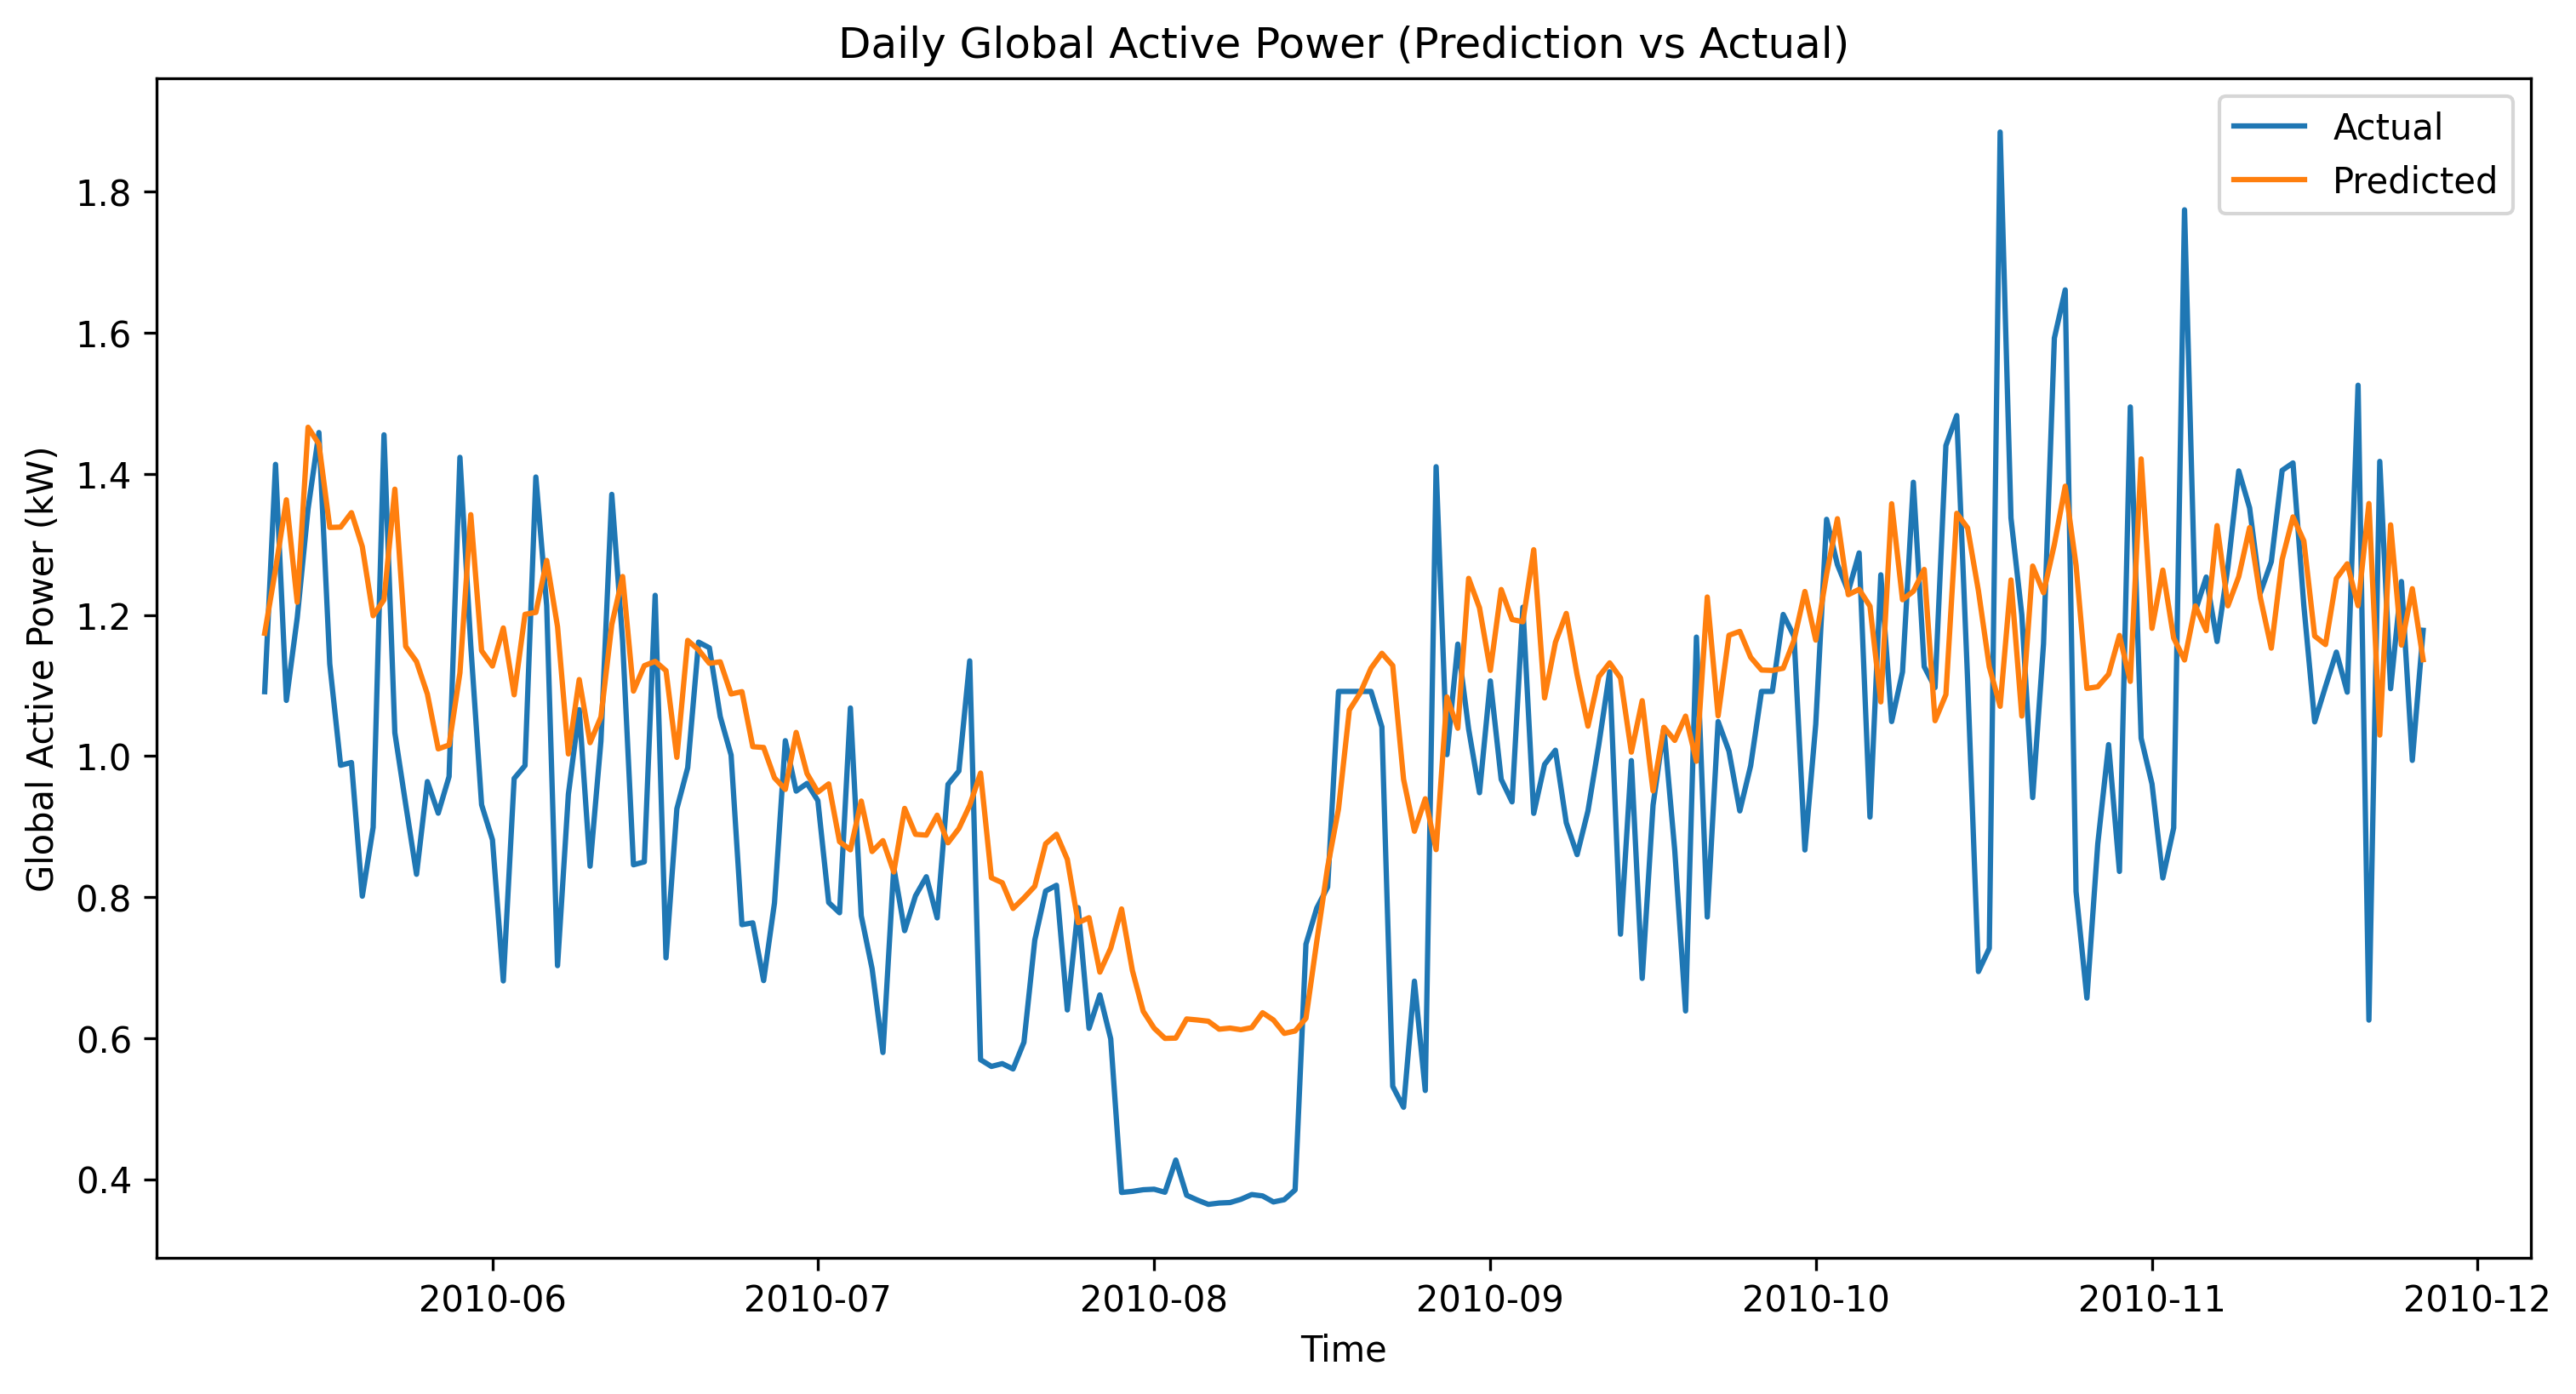

In [ ]:
# Define sequence length and features
sequence_length = 7              # Number of time steps to consider in each sequence
num_features = len(df2.columns)  # Number of features

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_df2) - sequence_length):
    seq = scaled_df2[i:i+sequence_length]
    label = scaled_df2[i+sequence_length][0]  # 'Global_Active_Power' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.80 * len(sequences))
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

# Check the shape of Train & Test Split
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# Create the LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))

# See the summary of model
model.summary()

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

# Fit the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test),
                    verbose=2, shuffle=False)

# Plot the training and validation loss (MSE)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

# Predict train and test data using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
y_train_copies = np.repeat(y_train.reshape(-1, 1), X_train.shape[-1], axis=-1)
true_y_train = scaler.inverse_transform(y_train_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict, df2.shape[1], axis=-1)
pred_y_train = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
y_test_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
true_y_test = scaler.inverse_transform(y_test_copies)[:,0]

# predicted values for test data
test_prediction_copies = np.repeat(test_predict, df2.shape[1], axis=-1)
pred_y_test = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print(f'\nTrain MAE: {mean_absolute_error(true_y_train, pred_y_train):.3f}')
print(f'Train MAPE: {mean_absolute_percentage_error(true_y_train, pred_y_train):.3f}')
print(f'Train MSE: {mean_squared_error(true_y_train, pred_y_train):.3f}')
print(f'Train RMSE: {np.sqrt(mean_squared_error(true_y_train, pred_y_train)):.3f}')

print(f'\nTest MAE: {mean_absolute_error(true_y_test, pred_y_test):.3f}')
print(f'Test MAPE: {mean_absolute_percentage_error(true_y_train, pred_y_train):.3f}')
print(f'Test MSE: {mean_squared_error(true_y_test, pred_y_test):.3f}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(true_y_test, pred_y_test)):.3f}')

# Plotting Daily Global Active Power (Prediction vs Actual)
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df2.index[-200:], true_y_test[-200:], label='Actual')
plt.plot(df2.index[-200:], pred_y_test[-200:], label='Predicted')
plt.title('Daily Global Active Power (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

## LSTM model-1 Adam(learning_rate=0.01, epochs=50, batch_size=64) sq=7

(1148, 7, 6) (1148,) (287, 7, 6) (287,)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                        │ (None, 100)                 │          42,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,901 (167.58 KB)

 Trainable params: 42,901 (167.58 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
18/18 - 5s - 257ms/step - loss: 0.0529 - val_loss: 0.0101
Epoch 2/50
18/18 - 0s - 22ms/step - loss: 0.0160 - val_loss: 0.0066
Epoch 3/50
18/18 - 0s - 20ms/step - loss: 0.0141 - val_loss: 0.0063
Epoch 4/50
18/18 - 0s - 13ms/step - loss: 0.0132 - val_loss: 0.0061
Epoch 5/50
18/18 - 0s - 7ms/step - loss: 0.0128 - val_loss: 0.0059
Epoch 6/50
18/18 - 0s - 7ms/step - loss: 0.0128 - val_loss: 0.0057
Epoch 7/50
18/18 - 0s - 8ms/step - loss: 0.0127 - val_loss: 0.0059
Epoch 8/50
18/18 - 0s - 6ms/step - loss: 0.0132 - val_loss: 0.0060
Epoch 9/50
18/18 - 0s - 6ms/step - loss: 0.0130 - val_loss: 0.0062
Epoch 10/50
18/18 - 0s - 6ms/step - loss: 0.0130 - val_loss: 0.0062
Epoch 11/50
18/18 - 0s - 7ms/step - loss: 0.0123 - val_loss: 0.0058
Epoch 12/50
18/18 - 0s - 8ms/step - loss: 0.0121 - val_loss: 0.0058
Epoch 13/50
18/18 - 0s - 7ms/step - loss: 0.0120 - val_loss: 0.0059
Epoch 14/50
18/18 - 0s - 7ms/step - loss: 0.0123 - val_loss: 0.0059
Epoch 15/50
18/18 - 0s - 8ms/step - loss: 0.0118 - v

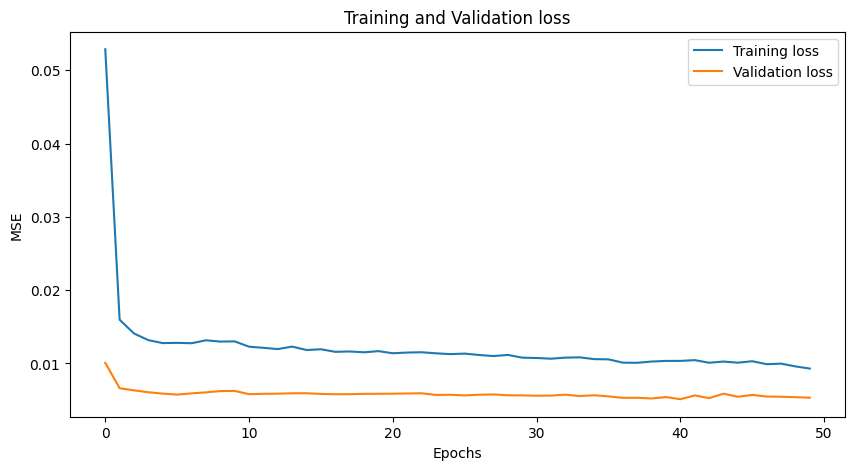

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Train MAE: 0.224
Train MAPE: 0.220
Train MSE: 0.094
Train RMSE: 0.307

Test MAE: 0.165
Test MAPE: 0.220
Test MSE: 0.052
Test RMSE: 0.229


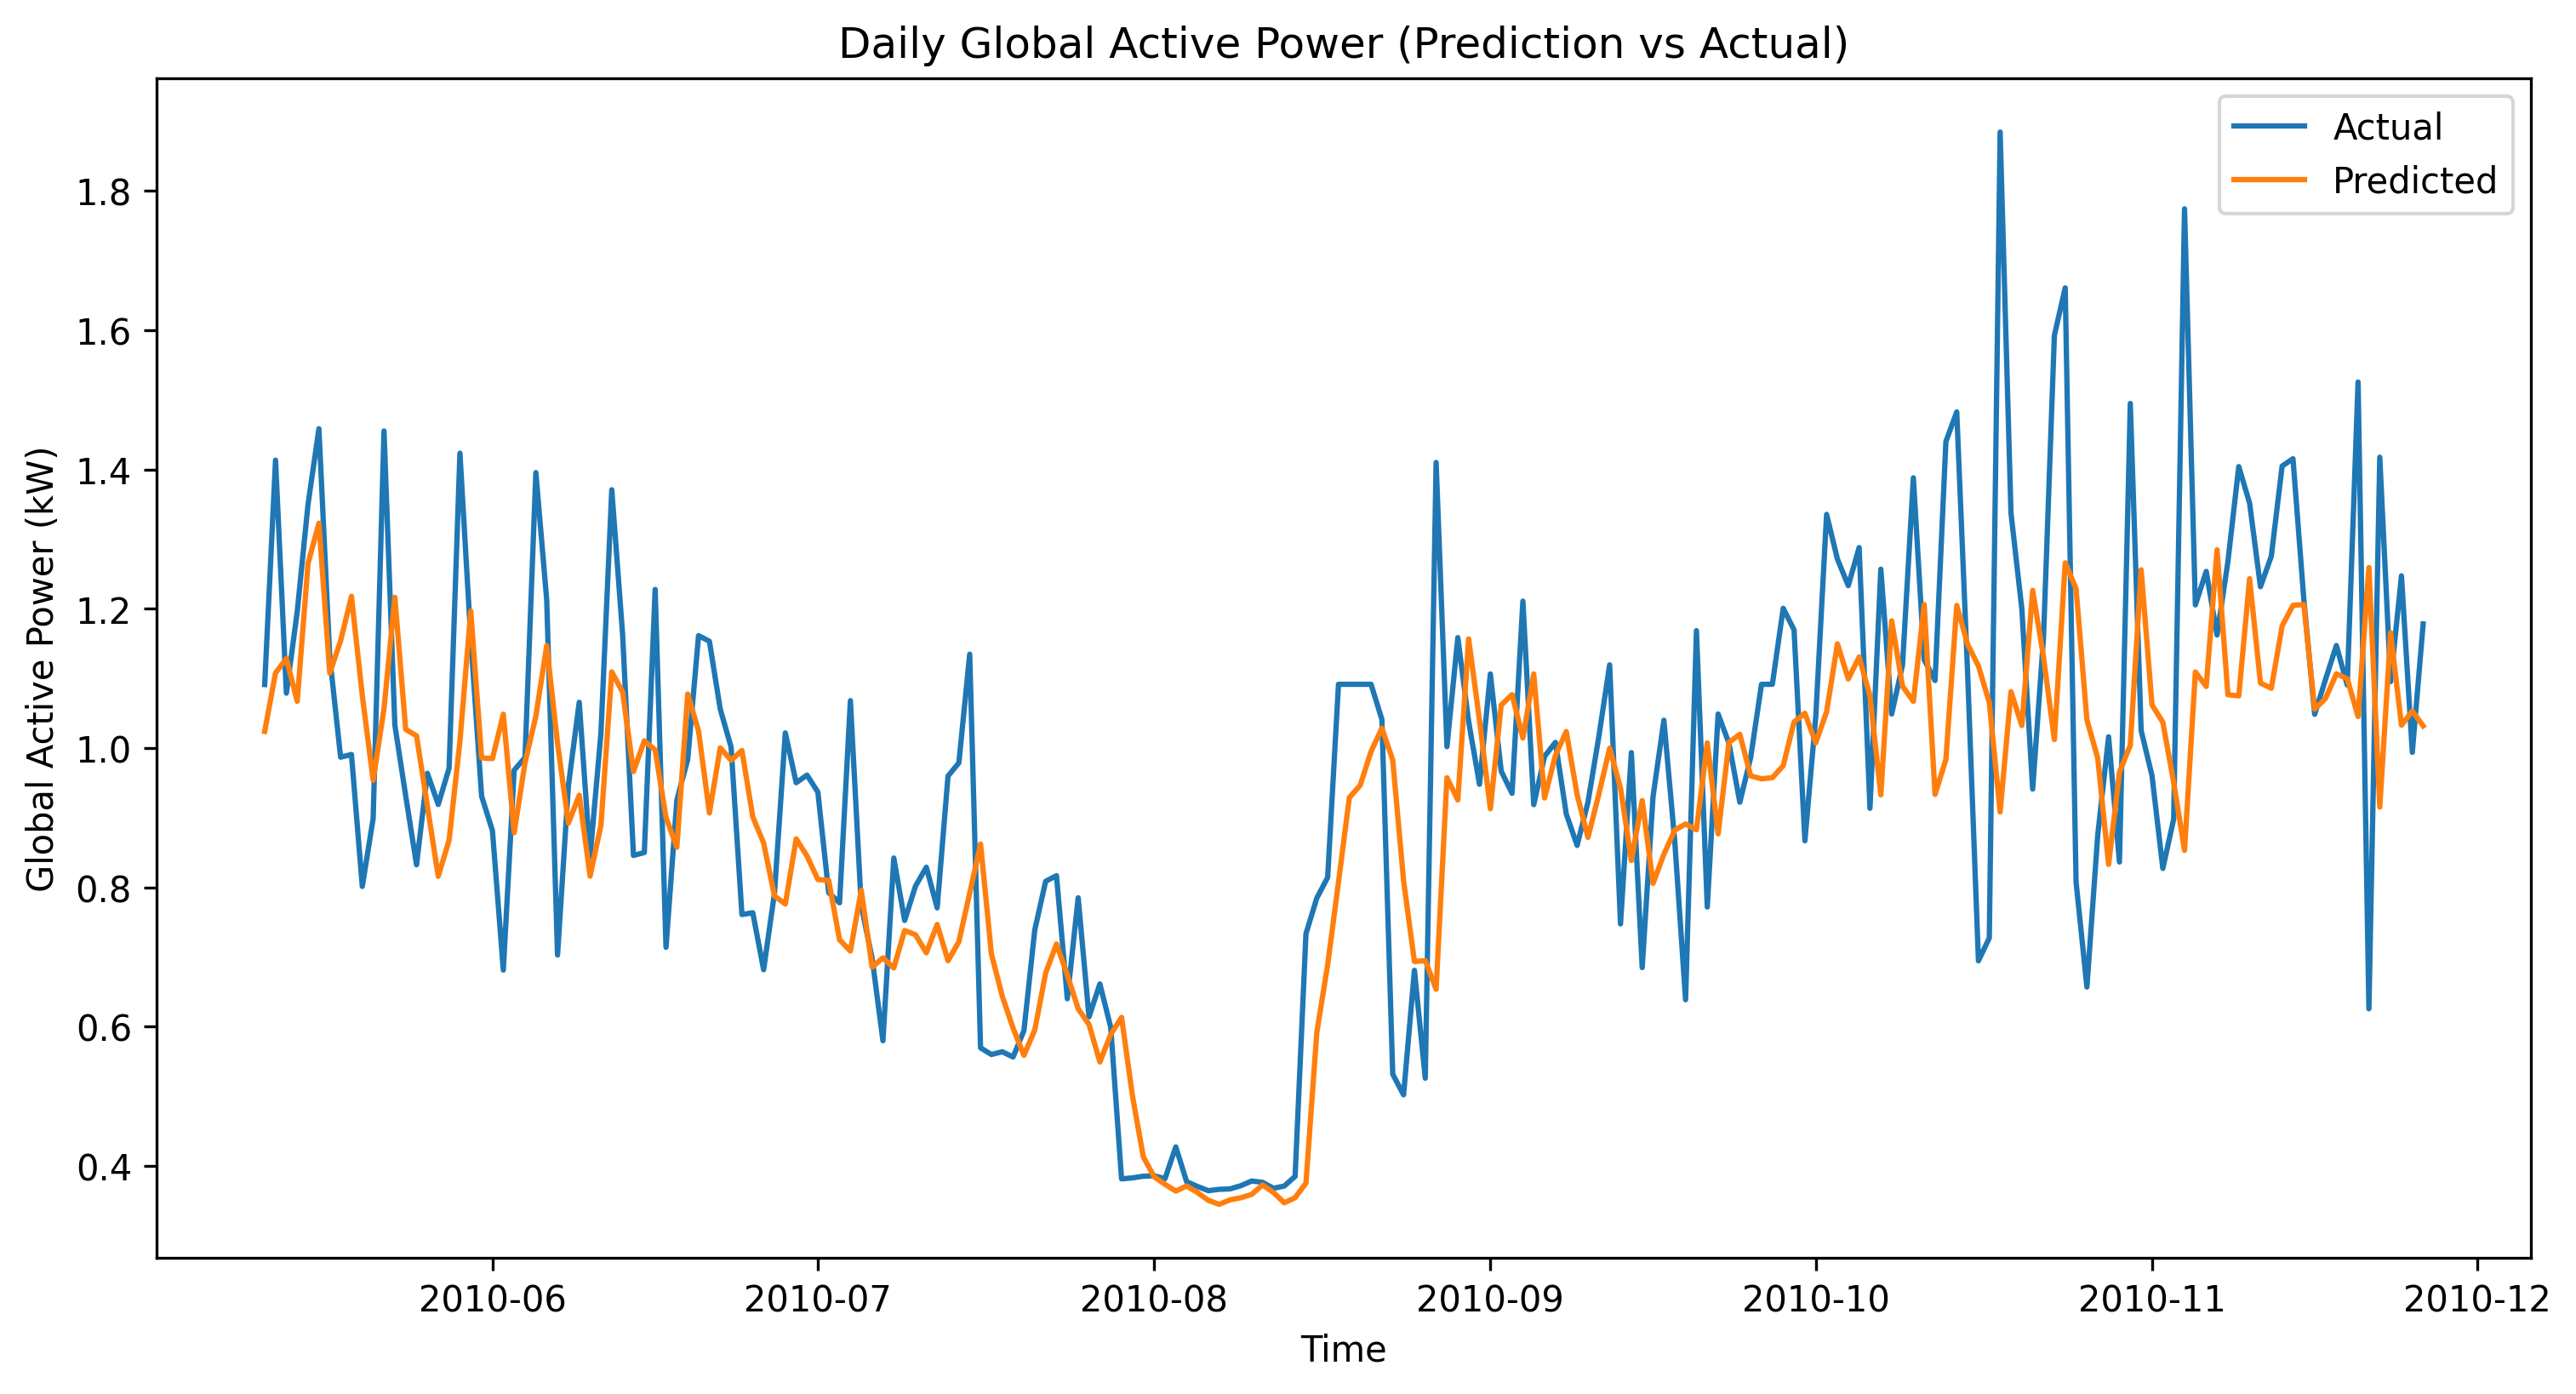

In [ ]:
# Define sequence length and features
sequence_length = 7              # Number of time steps to consider in each sequence
num_features = len(df2.columns)  # Number of features

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_df2) - sequence_length):
    seq = scaled_df2[i:i+sequence_length]
    label = scaled_df2[i+sequence_length][0]  # 'Global_Active_Power' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.80 * len(sequences))
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

# Check the shape of Train & Test Split
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# Create the LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))

# See the summary of model
model.summary()

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

# Fit the model
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test),
                    verbose=2, shuffle=False)

# Plot the training and validation loss (MSE)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

# Predict train and test data using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
y_train_copies = np.repeat(y_train.reshape(-1, 1), X_train.shape[-1], axis=-1)
true_y_train = scaler.inverse_transform(y_train_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict, df2.shape[1], axis=-1)
pred_y_train = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
y_test_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
true_y_test = scaler.inverse_transform(y_test_copies)[:,0]

# predicted values for test data
test_prediction_copies = np.repeat(test_predict, df2.shape[1], axis=-1)
pred_y_test = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print(f'\nTrain MAE: {mean_absolute_error(true_y_train, pred_y_train):.3f}')
print(f'Train MAPE: {mean_absolute_percentage_error(true_y_train, pred_y_train):.3f}')
print(f'Train MSE: {mean_squared_error(true_y_train, pred_y_train):.3f}')
print(f'Train RMSE: {np.sqrt(mean_squared_error(true_y_train, pred_y_train)):.3f}')

print(f'\nTest MAE: {mean_absolute_error(true_y_test, pred_y_test):.3f}')
print(f'Test MAPE: {mean_absolute_percentage_error(true_y_train, pred_y_train):.3f}')
print(f'Test MSE: {mean_squared_error(true_y_test, pred_y_test):.3f}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(true_y_test, pred_y_test)):.3f}')

# Plotting Daily Global Active Power (Prediction vs Actual)
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df2.index[-200:], true_y_test[-200:], label='Actual')
plt.plot(df2.index[-200:], pred_y_test[-200:], label='Predicted')
plt.title('Daily Global Active Power (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

## LSTM model-1 Adam(learning_rate=0.01, epochs=100, batch_size=64) sq=7

(1148, 7, 6) (1148,) (287, 7, 6) (287,)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 100)                 │          42,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,901 (167.58 KB)

 Trainable params: 42,901 (167.58 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
18/18 - 1s - 74ms/step - loss: 0.0461 - val_loss: 0.0086
Epoch 2/100
18/18 - 1s - 28ms/step - loss: 0.0156 - val_loss: 0.0066
Epoch 3/100
18/18 - 0s - 9ms/step - loss: 0.0135 - val_loss: 0.0063
Epoch 4/100
18/18 - 0s - 9ms/step - loss: 0.0130 - val_loss: 0.0061
Epoch 5/100
18/18 - 0s - 9ms/step - loss: 0.0129 - val_loss: 0.0058
Epoch 6/100
18/18 - 0s - 10ms/step - loss: 0.0132 - val_loss: 0.0061
Epoch 7/100
18/18 - 0s - 16ms/step - loss: 0.0136 - val_loss: 0.0064
Epoch 8/100
18/18 - 0s - 17ms/step - loss: 0.0134 - val_loss: 0.0066
Epoch 9/100
18/18 - 0s - 17ms/step - loss: 0.0132 - val_loss: 0.0063
Epoch 10/100
18/18 - 0s - 9ms/step - loss: 0.0127 - val_loss: 0.0062
Epoch 11/100
18/18 - 0s - 10ms/step - loss: 0.0126 - val_loss: 0.0060
Epoch 12/100
18/18 - 0s - 17ms/step - loss: 0.0122 - val_loss: 0.0060
Epoch 13/100
18/18 - 0s - 10ms/step - loss: 0.0122 - val_loss: 0.0059
Epoch 14/100
18/18 - 0s - 16ms/step - loss: 0.0120 - val_loss: 0.0060
Epoch 15/100
18/18 - 0s - 13ms/st

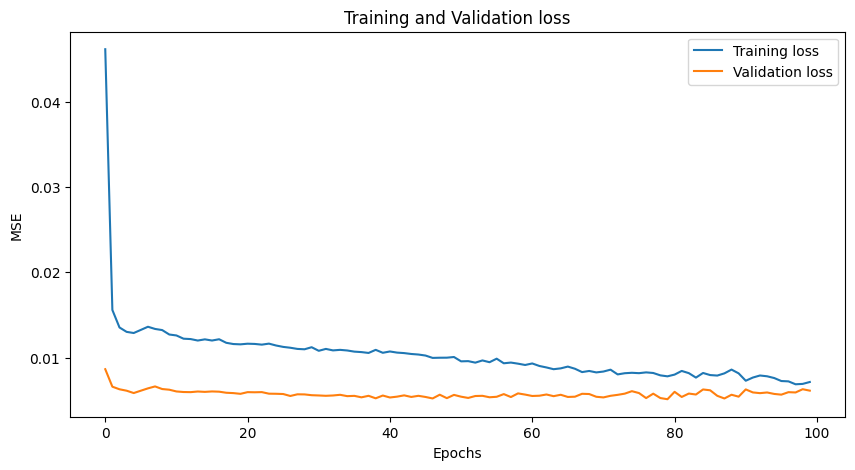

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Train MAE: 0.201
Train MAPE: 0.203
Train MSE: 0.072
Train RMSE: 0.269

Test MAE: 0.182
Test MAPE: 0.203
Test MSE: 0.060
Test RMSE: 0.246


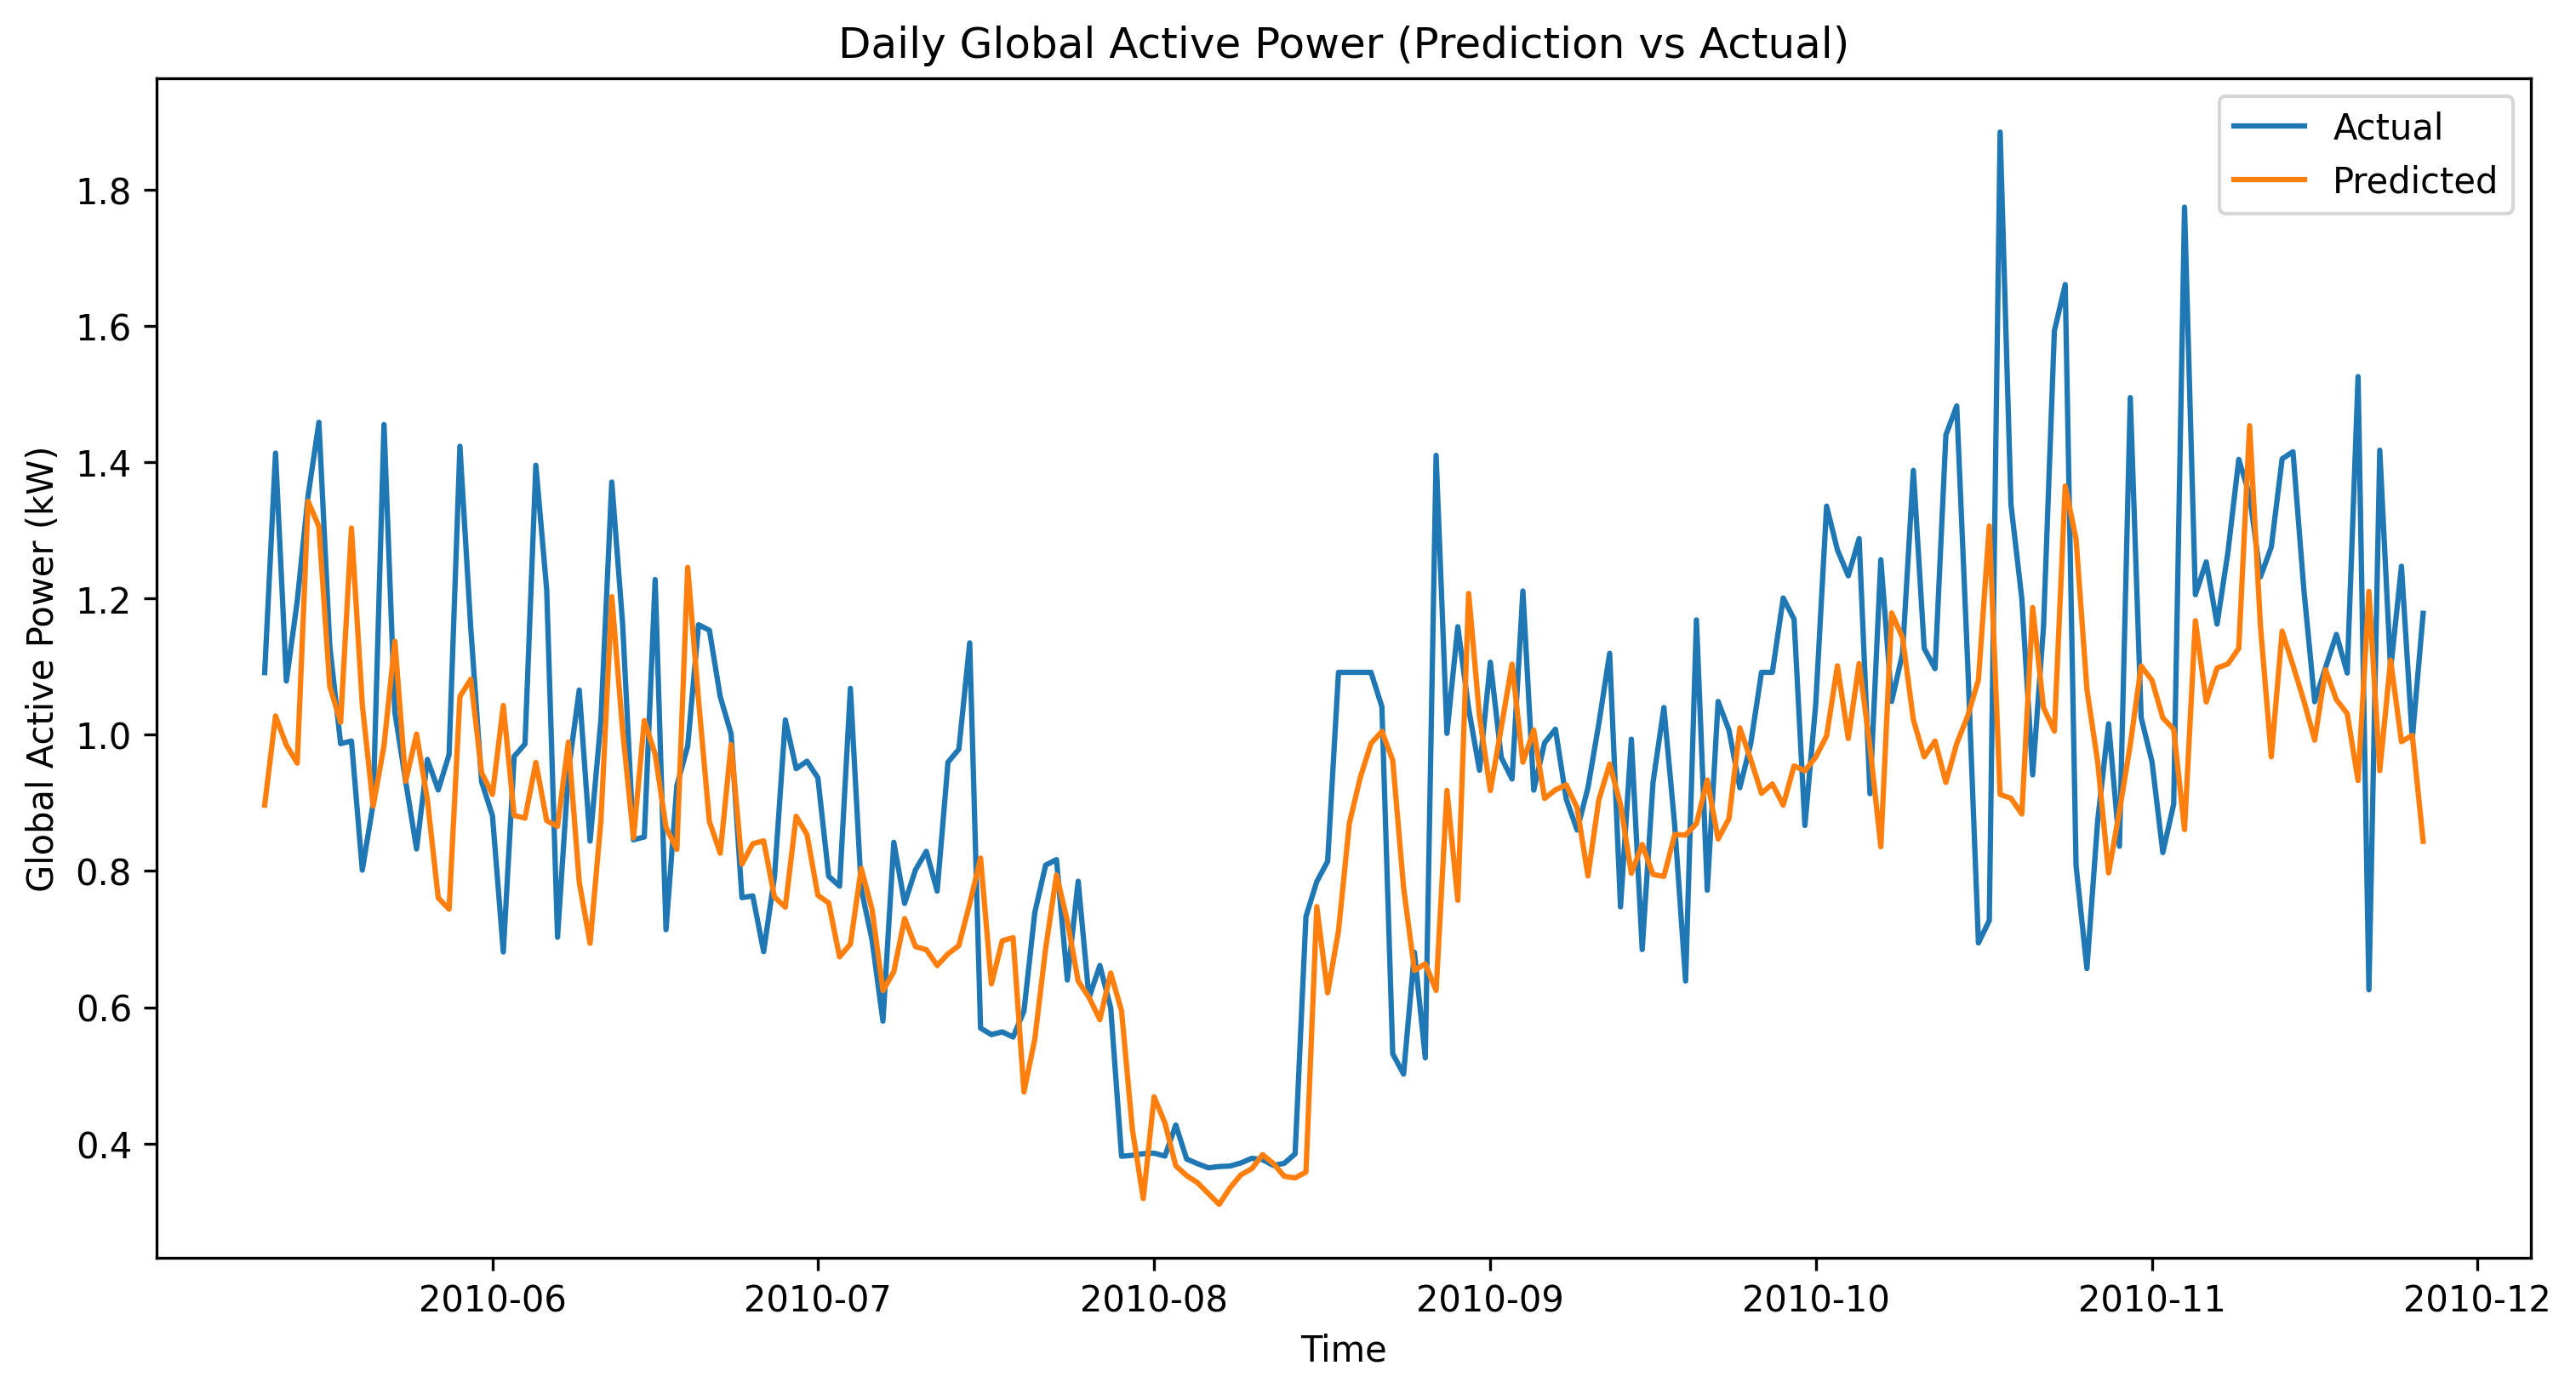

In [ ]:
# Define sequence length and features
sequence_length = 7             # Number of time steps to consider in each sequence
num_features = len(df2.columns)  # Number of features

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_df2) - sequence_length):
    seq = scaled_df2[i:i+sequence_length]
    label = scaled_df2[i+sequence_length][0]  # 'Global_Active_Power' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.80 * len(sequences))
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

# Check the shape of Train & Test Split
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# Create the LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))

# See the summary of model
model.summary()

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

# Fit the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test),
                    verbose=2, shuffle=False)

# Plot the training and validation loss (MSE)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

# Predict train and test data using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
y_train_copies = np.repeat(y_train.reshape(-1, 1), X_train.shape[-1], axis=-1)
true_y_train = scaler.inverse_transform(y_train_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict, df2.shape[1], axis=-1)
pred_y_train = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
y_test_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
true_y_test = scaler.inverse_transform(y_test_copies)[:,0]

# predicted values for test data
test_prediction_copies = np.repeat(test_predict, df2.shape[1], axis=-1)
pred_y_test = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print(f'\nTrain MAE: {mean_absolute_error(true_y_train, pred_y_train):.3f}')
print(f'Train MAPE: {mean_absolute_percentage_error(true_y_train, pred_y_train):.3f}')
print(f'Train MSE: {mean_squared_error(true_y_train, pred_y_train):.3f}')
print(f'Train RMSE: {np.sqrt(mean_squared_error(true_y_train, pred_y_train)):.3f}')

print(f'\nTest MAE: {mean_absolute_error(true_y_test, pred_y_test):.3f}')
print(f'Test MAPE: {mean_absolute_percentage_error(true_y_train, pred_y_train):.3f}')
print(f'Test MSE: {mean_squared_error(true_y_test, pred_y_test):.3f}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(true_y_test, pred_y_test)):.3f}')

# Plotting Daily Global Active Power (Prediction vs Actual)
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df2.index[-200:], true_y_test[-200:], label='Actual')
plt.plot(df2.index[-200:], pred_y_test[-200:], label='Predicted')
plt.title('Daily Global Active Power (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

## LSTM model-1 Adam(learning_rate=0.01, epochs=200, batch_size=128) sq=7

(1148, 7, 6) (1148,) (287, 7, 6) (287,)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 100)                 │          42,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,901 (167.58 KB)

 Trainable params: 42,901 (167.58 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
9/9 - 5s - 601ms/step - loss: 0.0520 - val_loss: 0.0118
Epoch 2/200
9/9 - 0s - 23ms/step - loss: 0.0139 - val_loss: 0.0072
Epoch 3/200
9/9 - 0s - 23ms/step - loss: 0.0155 - val_loss: 0.0061
Epoch 4/200
9/9 - 0s - 38ms/step - loss: 0.0133 - val_loss: 0.0071
Epoch 5/200
9/9 - 0s - 26ms/step - loss: 0.0110 - val_loss: 0.0058
Epoch 6/200
9/9 - 0s - 25ms/step - loss: 0.0114 - val_loss: 0.0060
Epoch 7/200
9/9 - 0s - 17ms/step - loss: 0.0118 - val_loss: 0.0058
Epoch 8/200
9/9 - 0s - 31ms/step - loss: 0.0113 - val_loss: 0.0056
Epoch 9/200
9/9 - 0s - 17ms/step - loss: 0.0110 - val_loss: 0.0056
Epoch 10/200
9/9 - 0s - 15ms/step - loss: 0.0110 - val_loss: 0.0057
Epoch 11/200
9/9 - 0s - 14ms/step - loss: 0.0111 - val_loss: 0.0057
Epoch 12/200
9/9 - 0s - 15ms/step - loss: 0.0113 - val_loss: 0.0058
Epoch 13/200
9/9 - 0s - 46ms/step - loss: 0.0117 - val_loss: 0.0061
Epoch 14/200
9/9 - 0s - 17ms/step - loss: 0.0114 - val_loss: 0.0057
Epoch 15/200
9/9 - 0s - 11ms/step - loss: 0.0111 - val_l

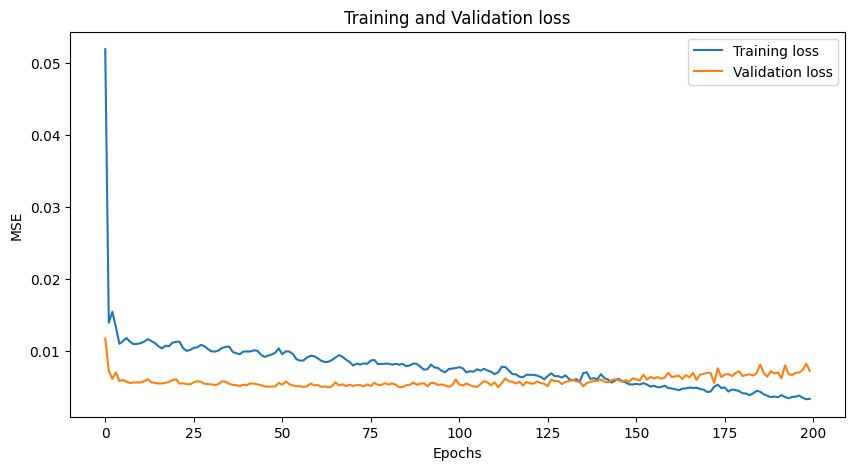

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Train MAE: 0.133
Train MAPE: 0.150
Train MSE: 0.029
Train RMSE: 0.169

Test MAE: 0.200
Test MAPE: 0.150
Test MSE: 0.072
Test RMSE: 0.268


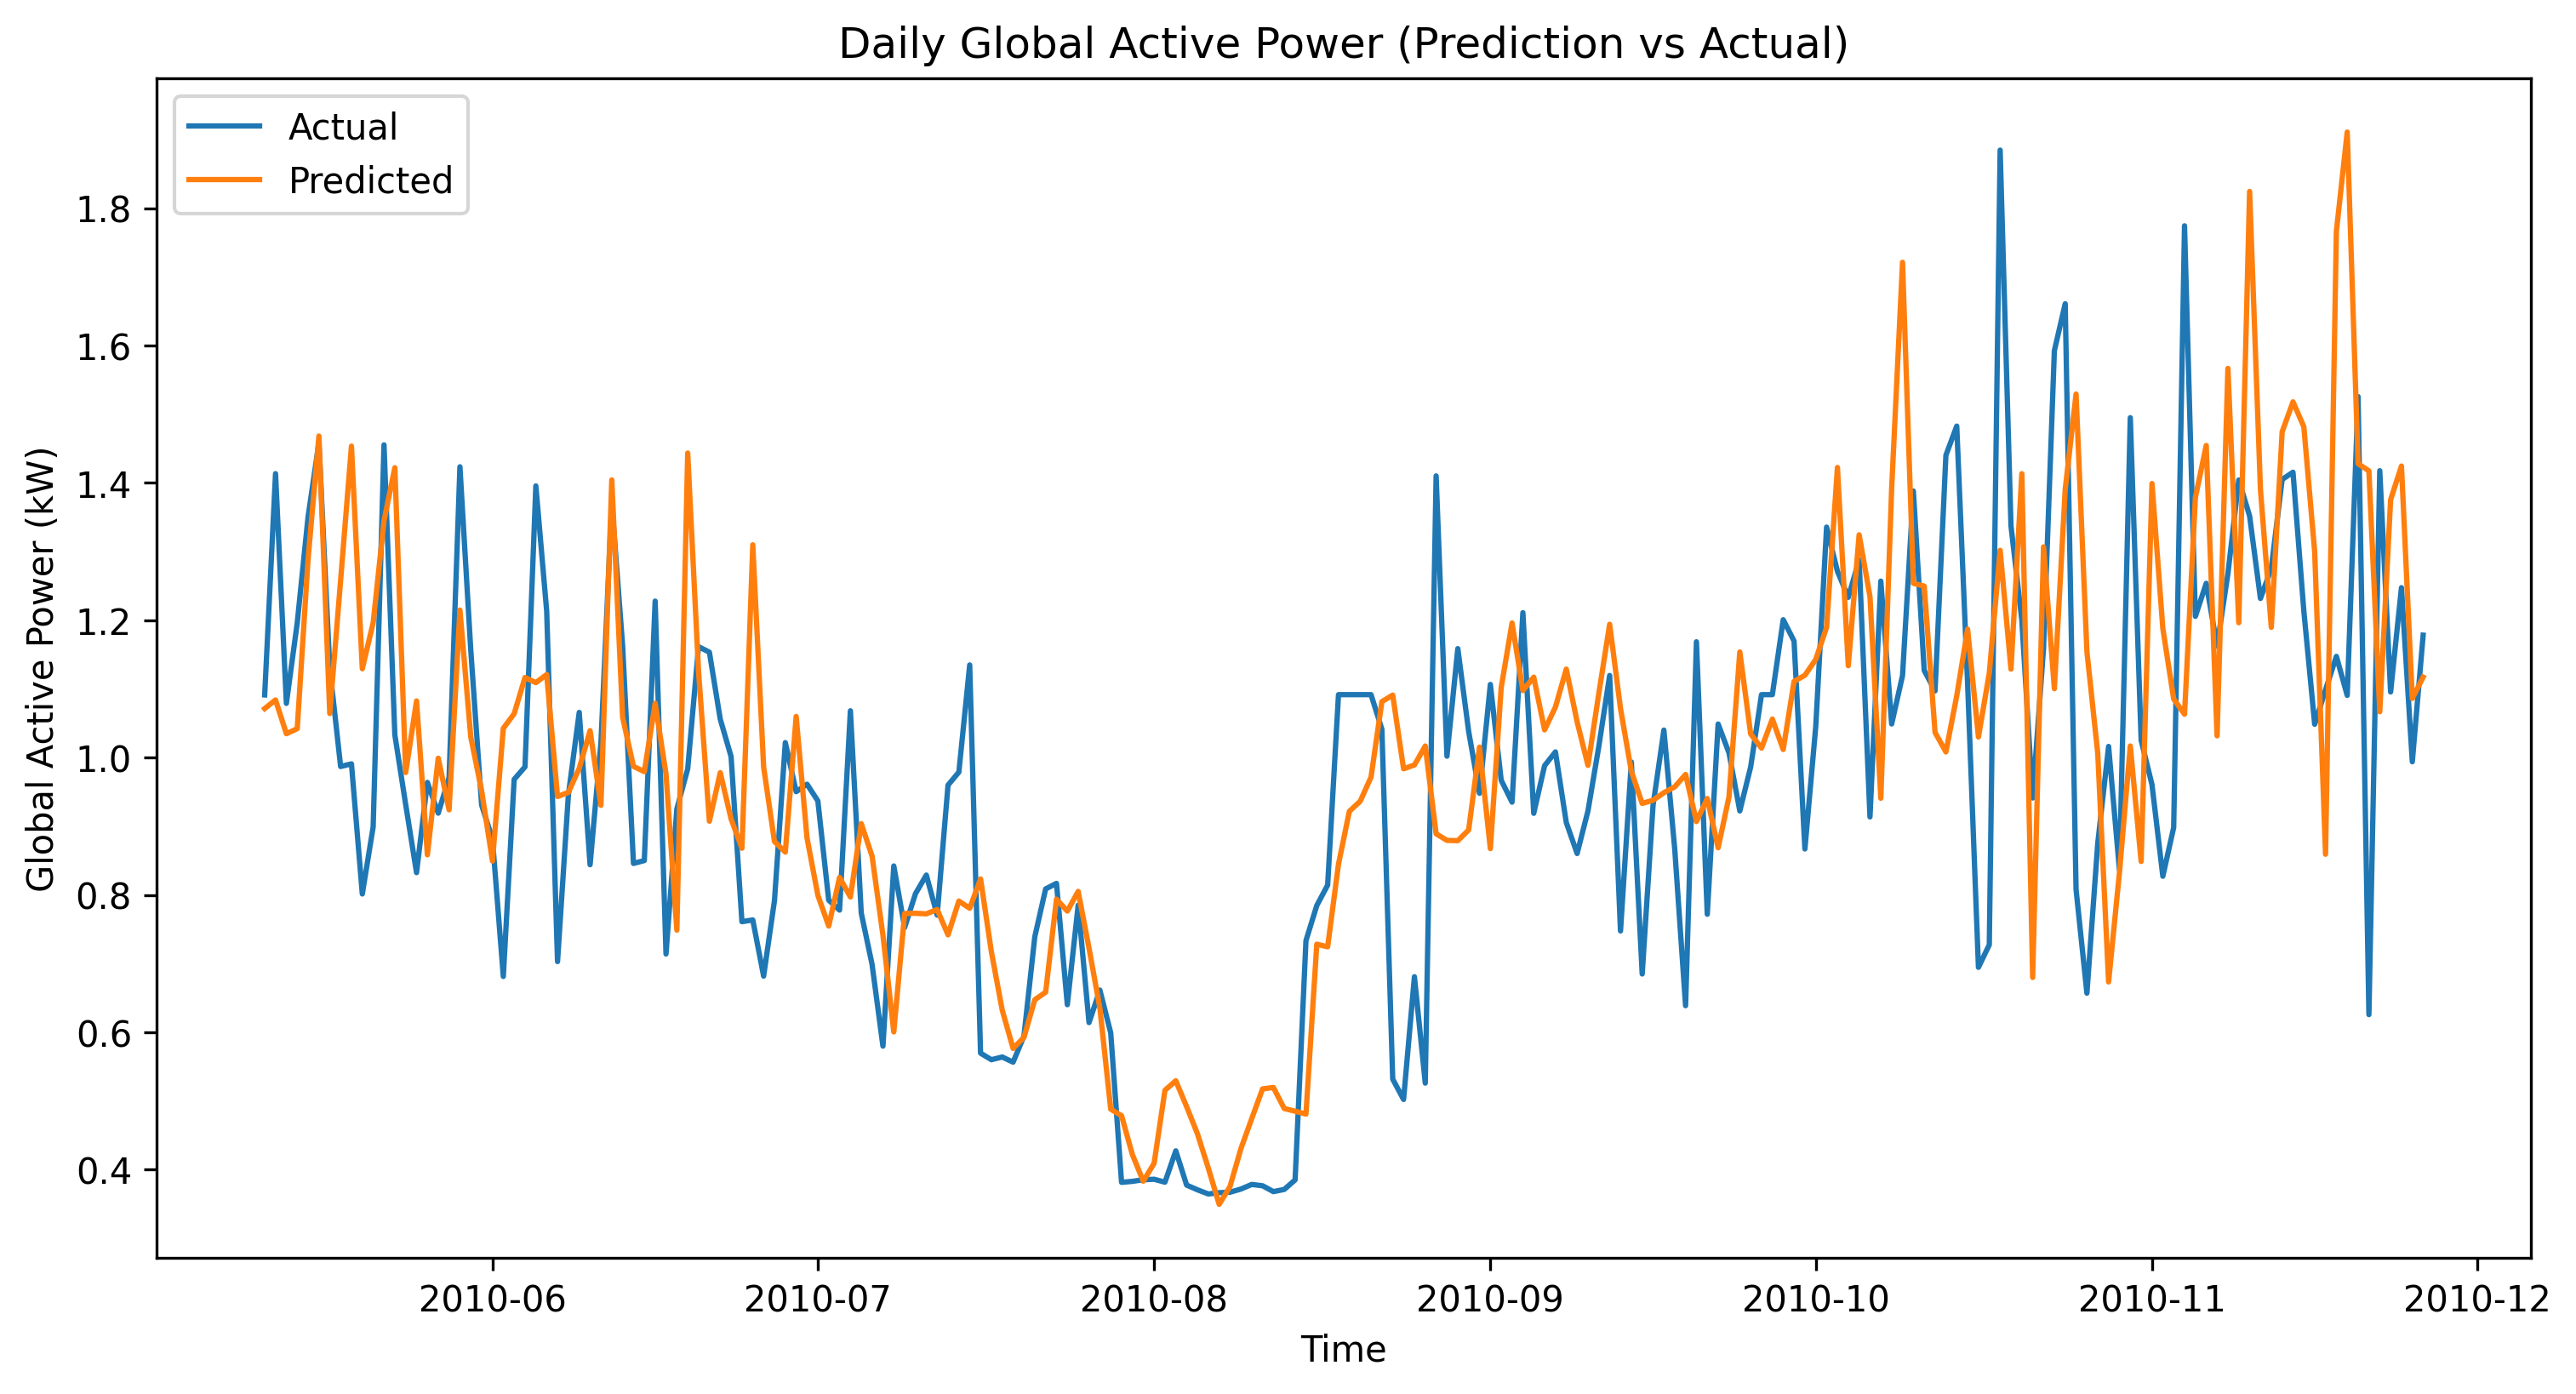

In [ ]:
# Define sequence length and features
sequence_length = 7             # Number of time steps to consider in each sequence
num_features = len(df2.columns)  # Number of features

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_df2) - sequence_length):
    seq = scaled_df2[i:i+sequence_length]
    label = scaled_df2[i+sequence_length][0]  # 'Global_Active_Power' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.80 * len(sequences))
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

# Check the shape of Train & Test Split
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# Create the LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))

# See the summary of model
model.summary()

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

# Fit the model
history = model.fit(X_train, y_train, epochs=200, batch_size=128, validation_data=(X_test, y_test),
                    verbose=2, shuffle=False)

# Plot the training and validation loss (MSE)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

# Predict train and test data using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
y_train_copies = np.repeat(y_train.reshape(-1, 1), X_train.shape[-1], axis=-1)
true_y_train = scaler.inverse_transform(y_train_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict, df2.shape[1], axis=-1)
pred_y_train = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
y_test_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
true_y_test = scaler.inverse_transform(y_test_copies)[:,0]

# predicted values for test data
test_prediction_copies = np.repeat(test_predict, df2.shape[1], axis=-1)
pred_y_test = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print(f'\nTrain MAE: {mean_absolute_error(true_y_train, pred_y_train):.3f}')
print(f'Train MAPE: {mean_absolute_percentage_error(true_y_train, pred_y_train):.3f}')
print(f'Train MSE: {mean_squared_error(true_y_train, pred_y_train):.3f}')
print(f'Train RMSE: {np.sqrt(mean_squared_error(true_y_train, pred_y_train)):.3f}')

print(f'\nTest MAE: {mean_absolute_error(true_y_test, pred_y_test):.3f}')
print(f'Test MAPE: {mean_absolute_percentage_error(true_y_train, pred_y_train):.3f}')
print(f'Test MSE: {mean_squared_error(true_y_test, pred_y_test):.3f}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(true_y_test, pred_y_test)):.3f}')

# Plotting Daily Global Active Power (Prediction vs Actual)
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df2.index[-200:], true_y_test[-200:], label='Actual')
plt.plot(df2.index[-200:], pred_y_test[-200:], label='Predicted')
plt.title('Daily Global Active Power (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()